# <div align=center> Implémenter un modèle de scoring </div>
## <div align=center> Partie 1 - Analyse </div>

La société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.
 
Pour accorder un crédit à la consommation, l’entreprise souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un client.

In [1]:
import dask_ml.model_selection as dcv
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
import timeit
import warnings
warnings.filterwarnings('ignore')
import glob
import shap
import random
import pickle
from collections import Counter
import os
from contextlib import contextmanager
import gc
import time
import xgboost as xgb
from scipy import interp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer, PolynomialFeatures, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve, cross_val_score, StratifiedKFold, cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, auc, accuracy_score, f1_score, precision_score, recall_score, make_scorer, fbeta_score, precision_recall_curve, average_precision_score
from classification_library import *
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 150)

## Chargement des données

In [2]:
%%time
def import_data():
    '''Importation des données et attribution d'un fichier à un dataframe

    Returns:
    - Un dataframe pour chaque fichier à notre disposition.'''
    
    # Training data
    app_train = pd.read_csv('data/application_train.csv')
    app_test = pd.read_csv('data/application_test.csv')
    bureau = pd.read_csv('data/bureau.csv')
    bureau_balance = pd.read_csv('data/bureau_balance.csv')
    credit_card_balance = pd.read_csv('data/credit_card_balance.csv')
    installments_payments = pd.read_csv('data/installments_payments.csv')
    POS_CASH_balance = pd.read_csv('data/POS_CASH_balance.csv')
    previous_application = pd.read_csv('data/previous_application.csv')
    return app_train,app_test,bureau,bureau_balance,credit_card_balance,installments_payments,POS_CASH_balance,previous_application

app_train,app_test,bureau,bureau_balance,credit_card_balance,installments_payments,POS_CASH_balance,previous_application = import_data()

CPU times: total: 19.6 s
Wall time: 23.2 s


In [3]:
def data_describe(folder):
    '''Vérifie le nombre de lignes, de colonnes, de valeurs manquantes et de valeurs dupliquées.
       Compte les types de colonnes.
       Indication par rapport à la mémoire
        Args:
        - Folder : Dossier contenant les différents fichiers.

        Returns:
        - comparative_table : Tableau comparant les données des différents fichiers.
     '''

    data_dict = {}
    for file in folder:
        data = pd.read_csv(file, encoding='iso-8859-1')
        data_dict[file] = [data.shape[0], 
                           data.shape[1],
                            round(data.isna().mean().mean() * 100, 2),
                            round(data.duplicated().mean().mean() * 100, 2),
                            data.select_dtypes(include=['object']).shape[1],
                            data.select_dtypes(include=['float']).shape[1],
                            data.select_dtypes(include=['int']).shape[1],
                            data.select_dtypes(include=['bool']).shape[1],
                            round(data.memory_usage().sum() / 1024**2, 3)]

    comparative_table = pd.DataFrame.from_dict(data_dict, 
                                                columns = ['Rows', 'Columns', '%NaN', '%Duplicate', 
                                                           'object_dtype','float_dtype', 'int_dtype', 
                                                           'bool_dtype', 'MB_Memory'], 
                                                orient='index')
    return comparative_table

In [4]:
data_describe(folder = glob.glob('data/*.csv'))

Rows  Columns   %NaN  %Duplicate  \
data\application_test.csv                   48744      121  23.81         0.0   
data\application_train.csv                 307511      122  24.40         0.0   
data\bureau.csv                           1716428       17  13.50         0.0   
data\bureau_balance.csv                  27299925        3   0.00         0.0   
data\credit_card_balance.csv              3840312       23   6.65         0.0   
data\HomeCredit_columns_description.csv       219        5  12.15         0.0   
data\installments_payments.csv           13605401        8   0.01         0.0   
data\POS_CASH_balance.csv                10001358        8   0.07         0.0   
data\previous_application.csv             1670214       37  17.98         0.0   
data\sample_submission.csv                  48744        2   0.00         0.0   

                                         object_dtype  float_dtype  int_dtype  \
data\application_test.csv                          16           65         40   
data\application_train.csv                         16           65         41   
data\bureau.csv                                     3            8          6   
data\bureau_balance.csv                             1            0          2   
data\credit_card_balance.csv                        1           15          7   
data\HomeCredit_columns_description.csv             4            0          1   
data\installments_payments.csv                      0            5          3   
data\POS_CASH_balance.csv                           1            2          5   
data\previous_application.csv                      16           15          6   
data\sample_submission.csv                          0            1          1   

                                         bool_dtype  MB_Memory  
data\application_test.csv                         0     44.998  
data\application_train.csv                        0    286.227  
data\bureau.csv                                   0    222.620  
data\bureau_balance.csv                           0    624.846  
data\credit_card_balance.csv                      0    673.883  
data\HomeCredit_columns_description.csv           0      0.008  
data\installments_payments.csv                    0    830.408  
data\POS_CASH_balance.csv                         0    610.435  
data\previous_application.csv                     0    471.481  
data\sample_submission.csv                        0      0.744

**application_train/application_test** : les principales données de formation et de test contenant des informations sur chaque demande de prêt chez Home Credit.   
**bureau** : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits précédents.  
**bureau_balance** : données mensuelles concernant les crédits précédents dans le bureau. Chaque ligne correspond à un mois de crédit précédent, et un crédit précédent unique peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.  
**previous_application** : demandes précédentes de prêts au Home Credit des clients qui ont des prêts dans les données de demande. Chaque prêt actuel dans les données de la demande peut avoir plusieurs prêts précédents.  
**POS_CASH_BALANCE** : données mensuelles sur les prêts au point de vente ou au comptant que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt en espèces. Un seul prêt précédent peut avoir plusieurs lignes.   
**credit_card_balance** : données mensuelles sur les cartes de crédit que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.  
**installments_payment** : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.  

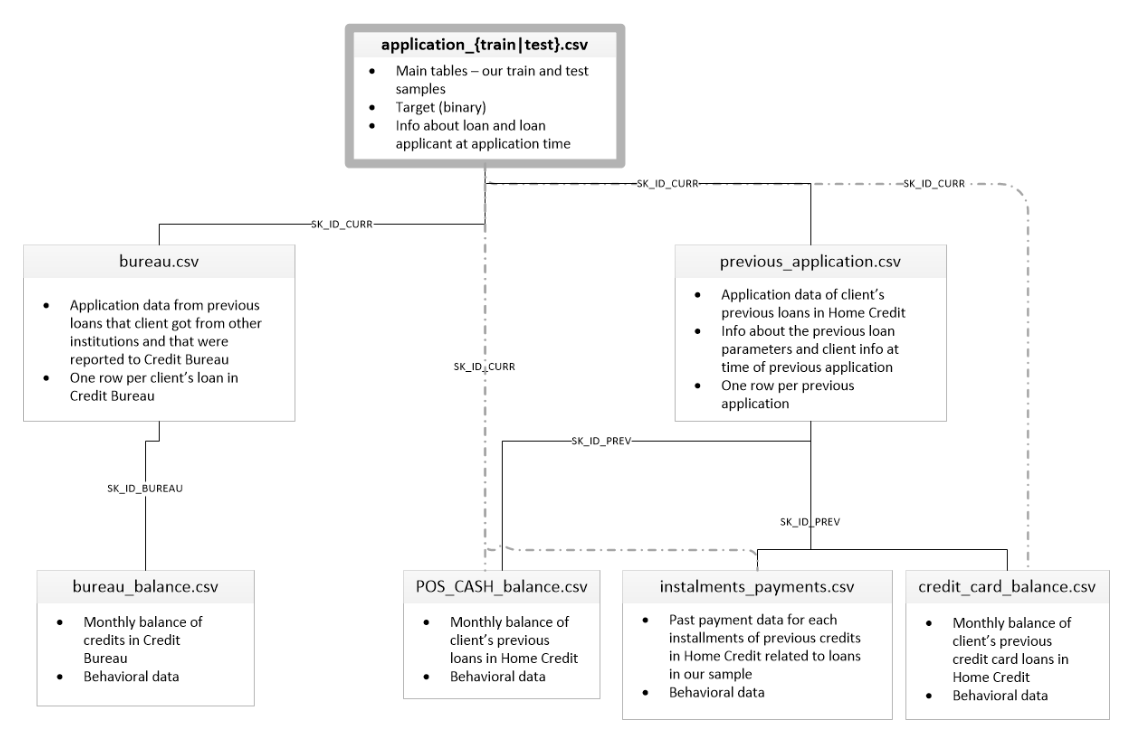

## Analyse exploratoire de données

### Application_train exploration initiale

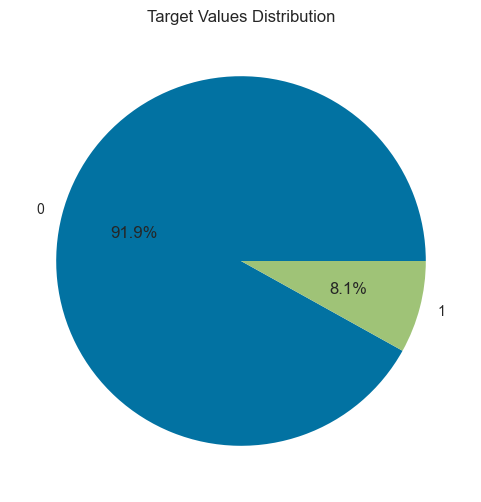

In [5]:
# Plot the pie chart of target values
plt.figure(figsize=(6,6))
proportions = app_train['TARGET'].value_counts(normalize=True)
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%')
plt.title('Target Values Distribution')
plt.show()

Nous sommes face à un problème de classification avec des classes déséquilibrées, pour ne pas influencer le modèle d'apprentissage automatique, nous pourrons pondérer les classes par  leur représentation dans les données ou créer de nouvelles observations de la classe minoritaire à l'aide de SMOTE

In [6]:
#Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [7]:
#Number of unique classes in each object column
app_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [8]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        '''Cette fonction prend en entrée un DataFrame et renvoie un tableau indiquant le nombre et le pourcentage 
        de valeurs manquantes pour chaque colonne de ce DataFrame.'''
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
missing_values_table(app_train)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                       214865               69.9
COMMONAREA_AVG                        214865               69.9
COMMONAREA_MODE                       214865               69.9
NONLIVINGAPARTMENTS_MEDI              213514               69.4
NONLIVINGAPARTMENTS_MODE              213514               69.4
NONLIVINGAPARTMENTS_AVG               213514               69.4
FONDKAPREMONT_MODE                    210295               68.4
LIVINGAPARTMENTS_MODE                 210199               68.4
LIVINGAPARTMENTS_MEDI                 210199               68.4
LIVINGAPARTMENTS_AVG                  210199               68.4
FLOORSMIN_MODE                        208642               67.8
FLOORSMIN_MEDI                        208642               67.8
FLOORSMIN_AVG                         208642               67.8
YEARS_BUILD_MODE                      204488               66.5
YEARS_BUILD_MEDI                      204488               66.5
YEARS_BUILD_AVG                       204488               66.5
OWN_CAR_AGE                           202929               66.0
LANDAREA_AVG                          182590               59.4
LANDAREA_MEDI                         182590               59.4
LANDAREA_MODE                         182590               59.4
BASEMENTAREA_MEDI                     179943               58.5
BASEMENTAREA_AVG                      179943               58.5
BASEMENTAREA_MODE                     179943               58.5
EXT_SOURCE_1                          173378               56.4
NONLIVINGAREA_MEDI                    169682               55.2
NONLIVINGAREA_MODE                    169682               55.2
NONLIVINGAREA_AVG                     169682               55.2
ELEVATORS_MEDI                        163891               53.3
ELEVATORS_MODE                        163891               53.3
ELEVATORS_AVG                         163891               53.3
WALLSMATERIAL_MODE                    156341               50.8
APARTMENTS_MODE                       156061               50.7
APARTMENTS_MEDI                       156061               50.7
APARTMENTS_AVG                        156061               50.7
ENTRANCES_MODE                        154828               50.3
ENTRANCES_AVG                         154828               50.3
ENTRANCES_MEDI                        154828               50.3
LIVINGAREA_MEDI                       154350               50.2
LIVINGAREA_MODE                       154350               50.2
LIVINGAREA_AVG                        154350               50.2
HOUSETYPE_MODE                        154297               50.2
FLOORSMAX_MEDI                        153020               49.8
FLOORSMAX_AVG                         153020               49.8
FLOORSMAX_MODE                        153020               49.8
YEARS_BEGINEXPLUATATION_AVG           150007               48.8
YEARS_BEGINEXPLUATATION_MEDI          150007               48.8
YEARS_BEGINEXPLUATATION_MODE          150007               48.8
TOTALAREA_MODE                        148431               48.3
EMERGENCYSTATE_MODE                   145755               47.4
OCCUPATION_TYPE                        96391               31.3
EXT_SOURCE_3                           60965               19.8
AMT_REQ_CREDIT_BUREAU_WEEK             41519               13.5
AMT_REQ_CREDIT_BUREAU_DAY              41519               13.5
AMT_REQ_CREDIT_BUREAU_MON              41519               13.5
AMT_REQ_CREDIT_BUREAU_QRT              41519               13.5
AMT_REQ_CREDIT_BUREAU_HOUR             41519               13.5
AMT_REQ_CREDIT_BUREAU_YEAR             41519               13.5
NAME_TYPE_SUITE                         1292                0.4
DEF_30_CNT_SOCIAL_CIRCLE                1021                0.3
OBS_60_CNT_SOCIAL_CIRCLE                1021                0.3
DEF_60_CNT_SOCIAL_CIRCLE                1021                0.3
OBS_30_CNT_SOCIAL_CIRCLE                1021                0.

In [9]:
#Display correlations
print('Most Positive Correlations:\n', app_train.corr()['TARGET'].sort_values().tail(15))
print('Most Negative Correlations:\n', app_train.corr()['TARGET'].sort_values().head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
R

Regardons certaines des corrélations les plus significatives : la corrélation DAYS_BIRTH est la plus positive. En regardant la documentation, DAYS_BIRTH est l'âge en jours du client au moment du prêt en jours négatifs. La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt (c'est-à-dire que la cible == 0).   
Ce n'est pas très instinctif, nous allons donc prendre la valeur absolue de la caractéristique afin d'avoir une corrélation négative

In [10]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

Au fur et à mesure que le client vieillit, il existe une relation linéaire négative avec l'objectif, ce qui signifie que plus les clients vieillissent, plus ils ont tendance à rembourser leurs prêts dans les délais.

Pour visualiser l'effet de l'âge sur la cible, nous allons réaliser un graphique d'estimation de la densité du noyau (KDE) coloré par la valeur de la cible.

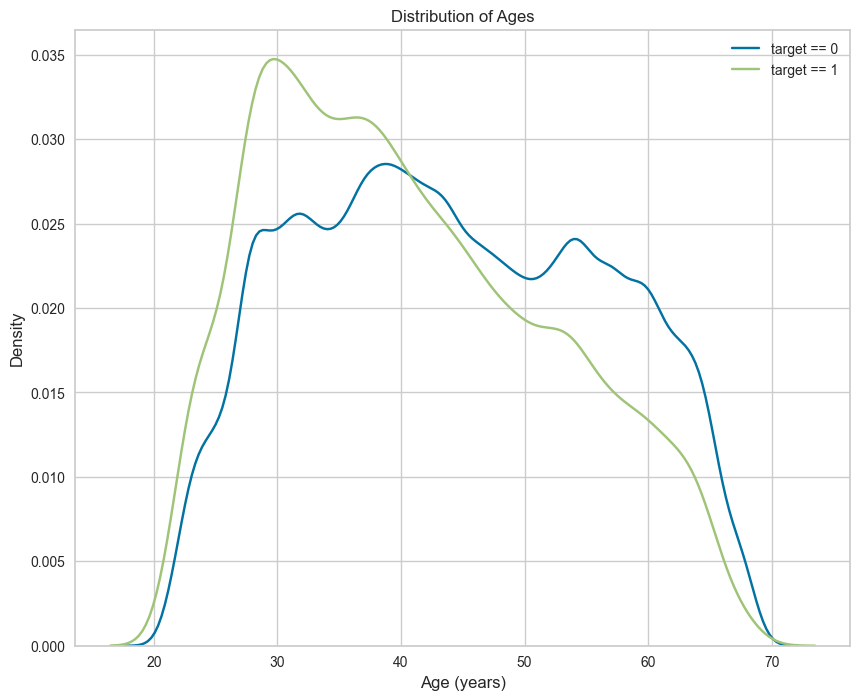

In [11]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

Ensuite, nous pouvons examiner la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

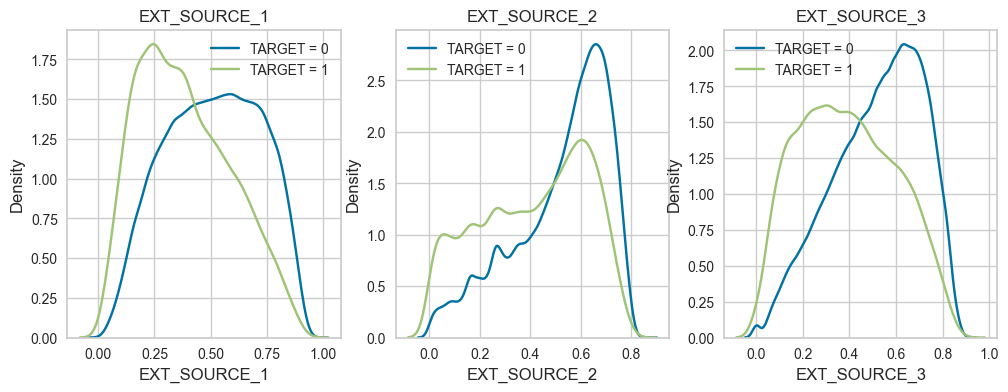

In [12]:
# Créer un subplot pour chaque graphique
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Boucle pour chaque variable EXT_SOURCE
for i, var in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    # Filtrer les données par modalité de TARGET
    for target in [0, 1]:
        data = app_train[app_train['TARGET'] == target][var]
        # Tracer la courbe de densité
        sns.kdeplot(data, ax=axs[i], label=f'TARGET = {target}')
    axs[i].set_title(var)
    axs[i].legend()

plt.show()

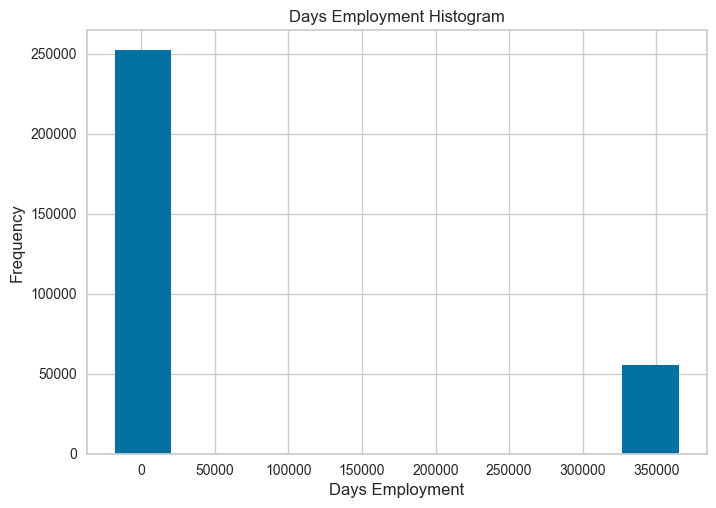

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


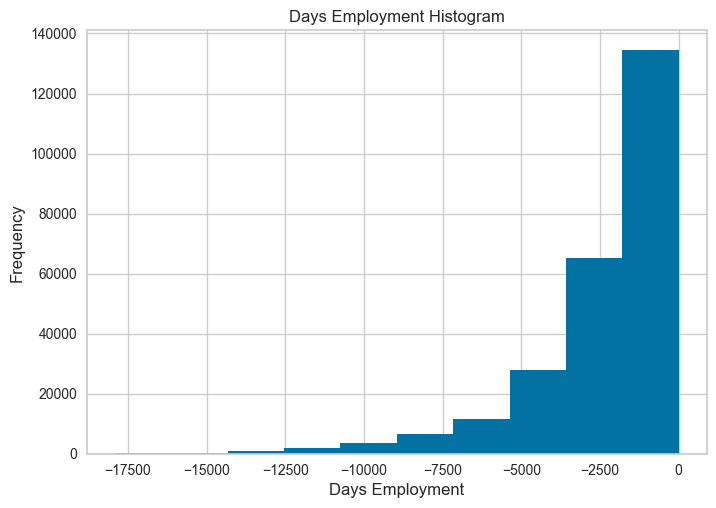

In [13]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')
plt.show()

anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')
plt.show()

In [14]:
def plot_pie_charts(df, column):
    """
    Plots two pie charts side by side - one showing the frequency of values for a specific column
    and the other showing the percentage of target values equal to 1 for the same column.

    Parameters:
    df (pandas.DataFrame): The Pandas dataframe that you want to plot the data from.
    column (str): The name of the column in the dataframe that you want to plot.

    Returns:
    None
    """
    unique_values = df[column].unique()
    custom_palette = sns.color_palette("bright", len(unique_values)).as_hex()
    color_dict = dict(zip(unique_values, custom_palette))

    fig, axs = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [1, 1]})

    # plot first pie chart
    counts = df[column].value_counts()
    counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axs[0], colors=[color_dict[c] for c in counts.index], labels= None)
    axs[0].set_title(f"Distribution de {column}", fontsize=12)
    axs[0].legend(loc="lower left",  bbox_to_anchor=(0.6, -0.3), title="Modalités", title_fontsize=14, labels=counts.index)

    # plot second pie chart
    category_percentage = df[[column, 'TARGET']].groupby([column], as_index=False).mean()
    category_percentage.sort_values(by='TARGET', ascending=False, inplace=True)
    axs[1].pie(category_percentage['TARGET'], labels=None, autopct='%1.1f%%', startangle=90, colors=[color_dict[c] for c in category_percentage[column]])
    axs[1].set_title(f"Pourcentage de TARGET=1 pour chaque modalité de {column}", fontsize=12)
    axs[1].legend(loc="lower right", bbox_to_anchor=(0.4, -0.3), title="Modalités", title_fontsize=14, labels=category_percentage[column])

    plt.show()

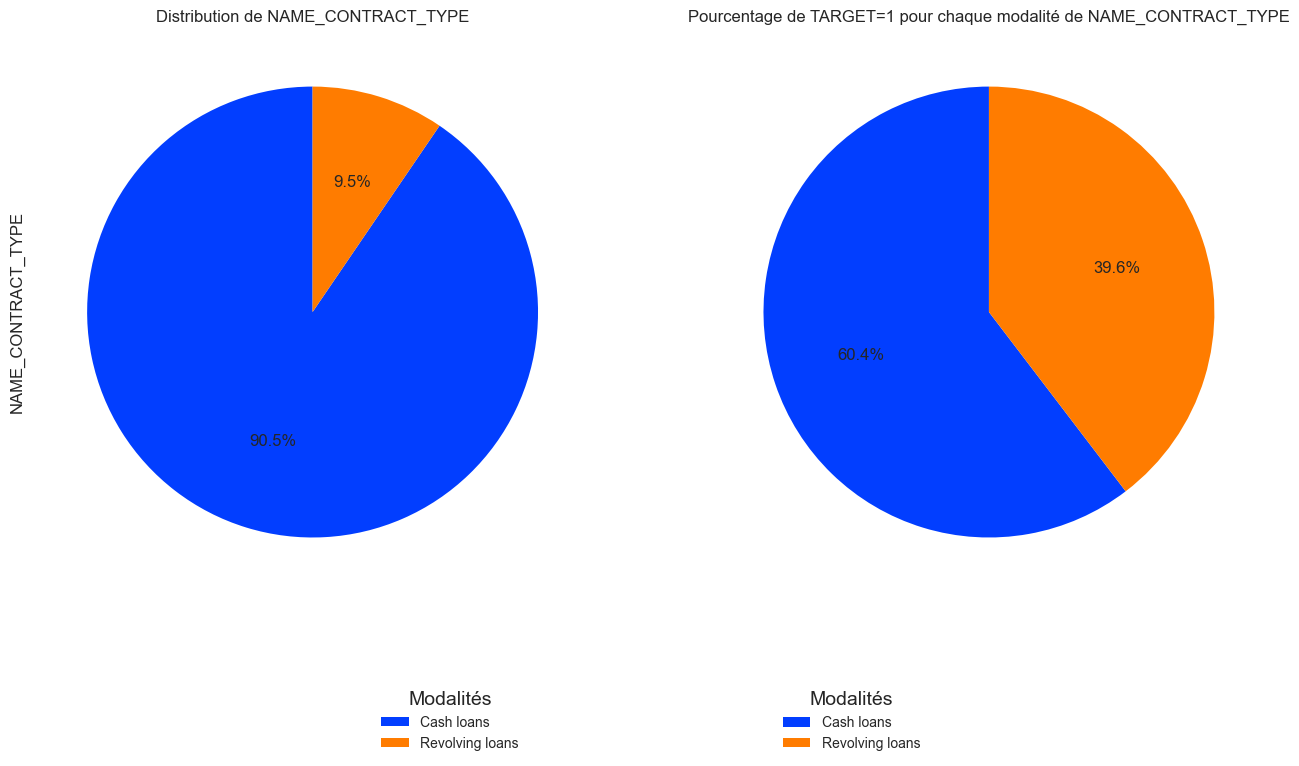

In [15]:
plot_pie_charts(app_train, 'NAME_CONTRACT_TYPE')

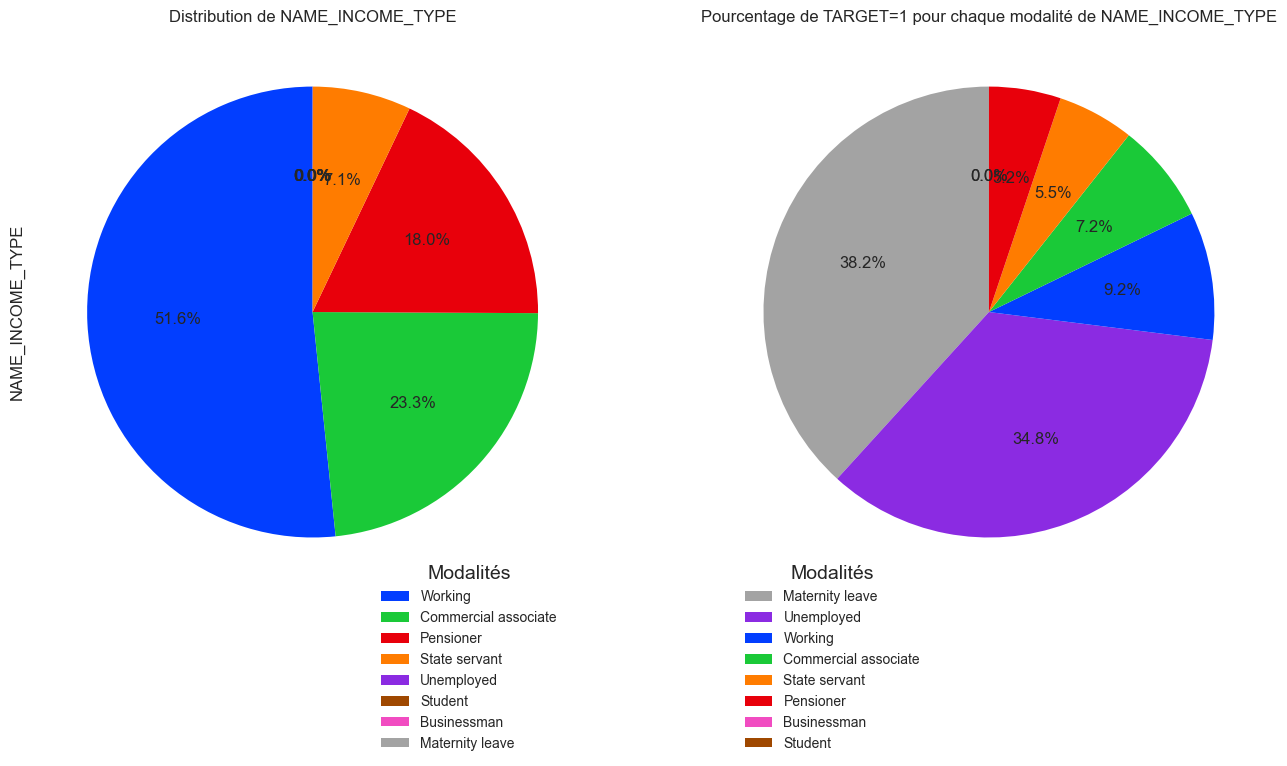

In [16]:
plot_pie_charts(app_train, 'NAME_INCOME_TYPE')

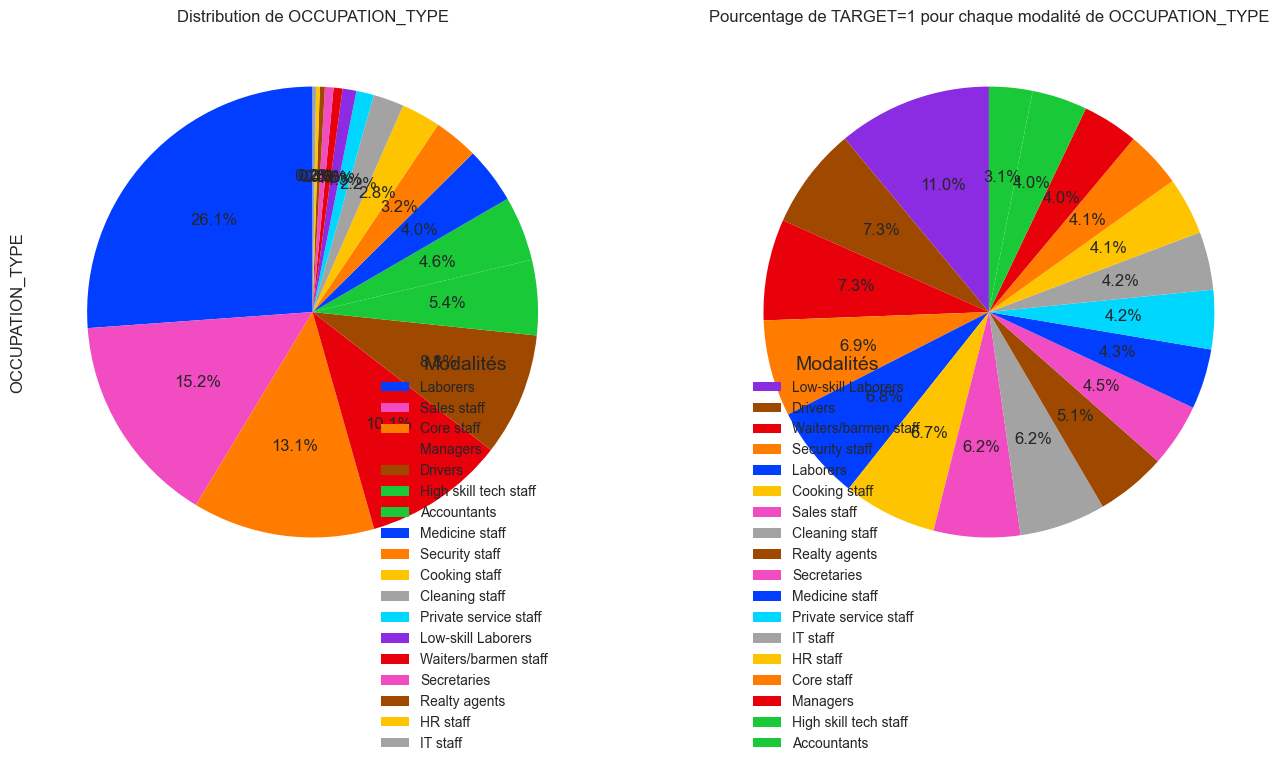

In [17]:
plot_pie_charts(app_train, 'OCCUPATION_TYPE')

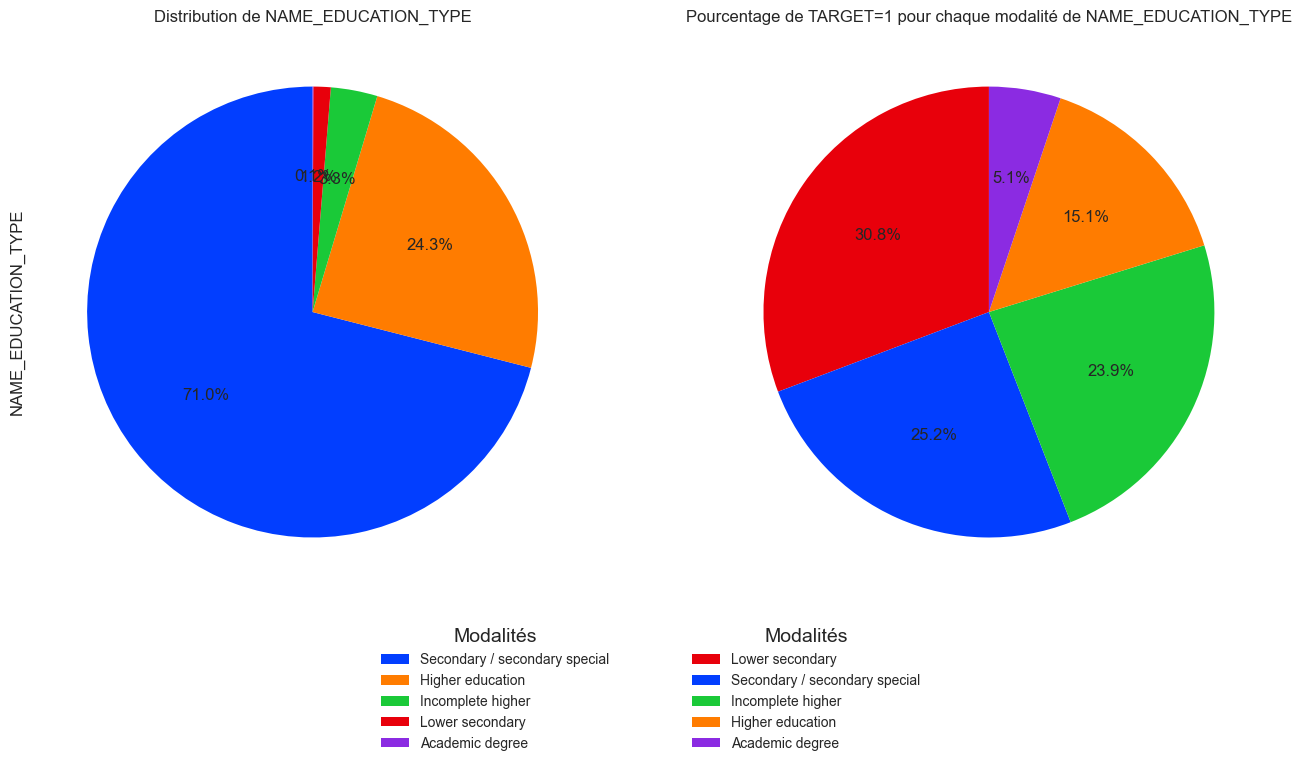

In [18]:
plot_pie_charts(app_train, 'NAME_EDUCATION_TYPE')

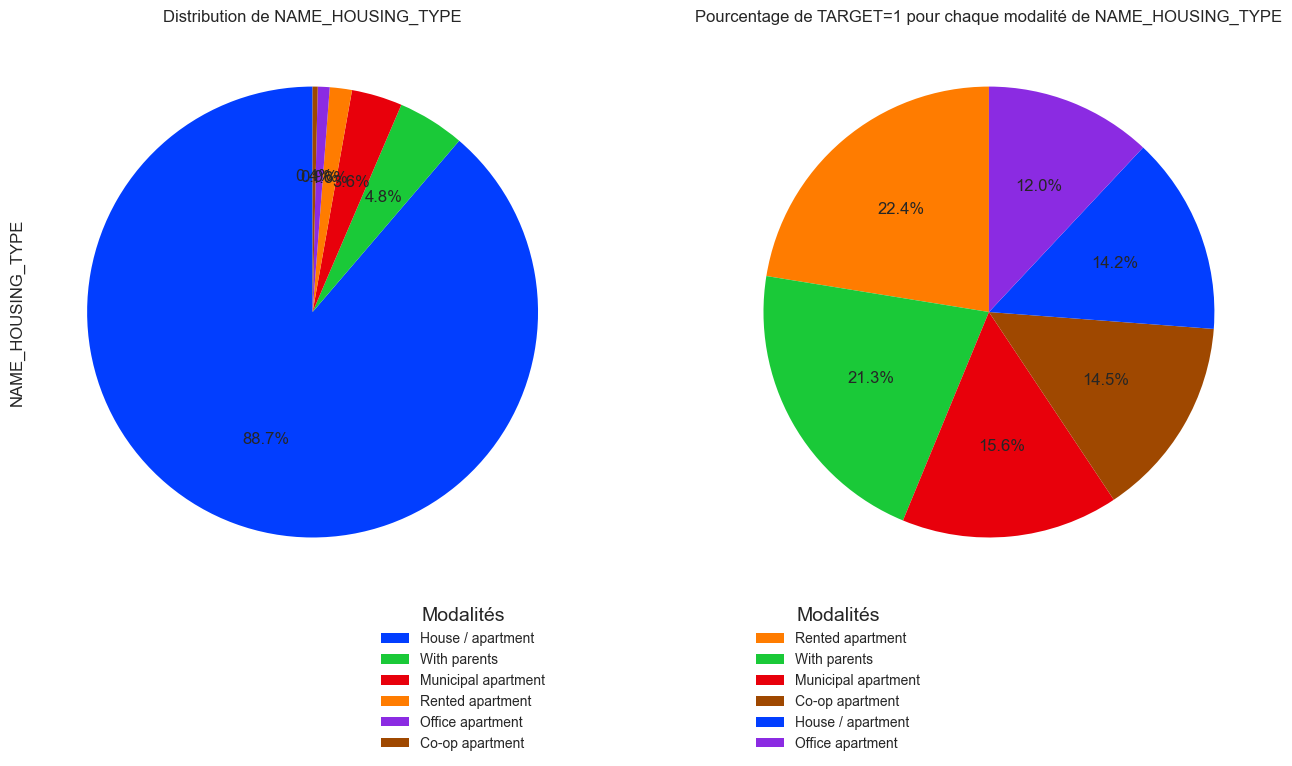

In [19]:
plot_pie_charts(app_train, 'NAME_HOUSING_TYPE')

### Autres jeu de données à disposition

#### Bureau data
Il s'agit ici des données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit antérieur a sa propre ligne dans le bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits antérieurs.

In [20]:
bureau

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                         0               -153.0             -153.0   
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                           NaN                   0        91323.00   
1                           NaN                   0       225000.00   
2                           NaN                   0       464323.50   
3                           NaN                   0        90000.00   
4                       77674.5                   0      2700000.00   
...                         ...                 ...             ...   
1716423                     0.0                   0        11250.00   
1716424                  5476.5                   0        38130.84   
1716425                     NaN                   0        15570.00   
1716426                     NaN                   0        36000.00   
1716427                     NaN                   0        22500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                        0.0                   NaN                     0.0   
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
3            Credit card                 -16          NaN  
4        Consumer credit                 -21          NaN  
...                  ...                 ... 

In [21]:
application_bureau_train = app_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

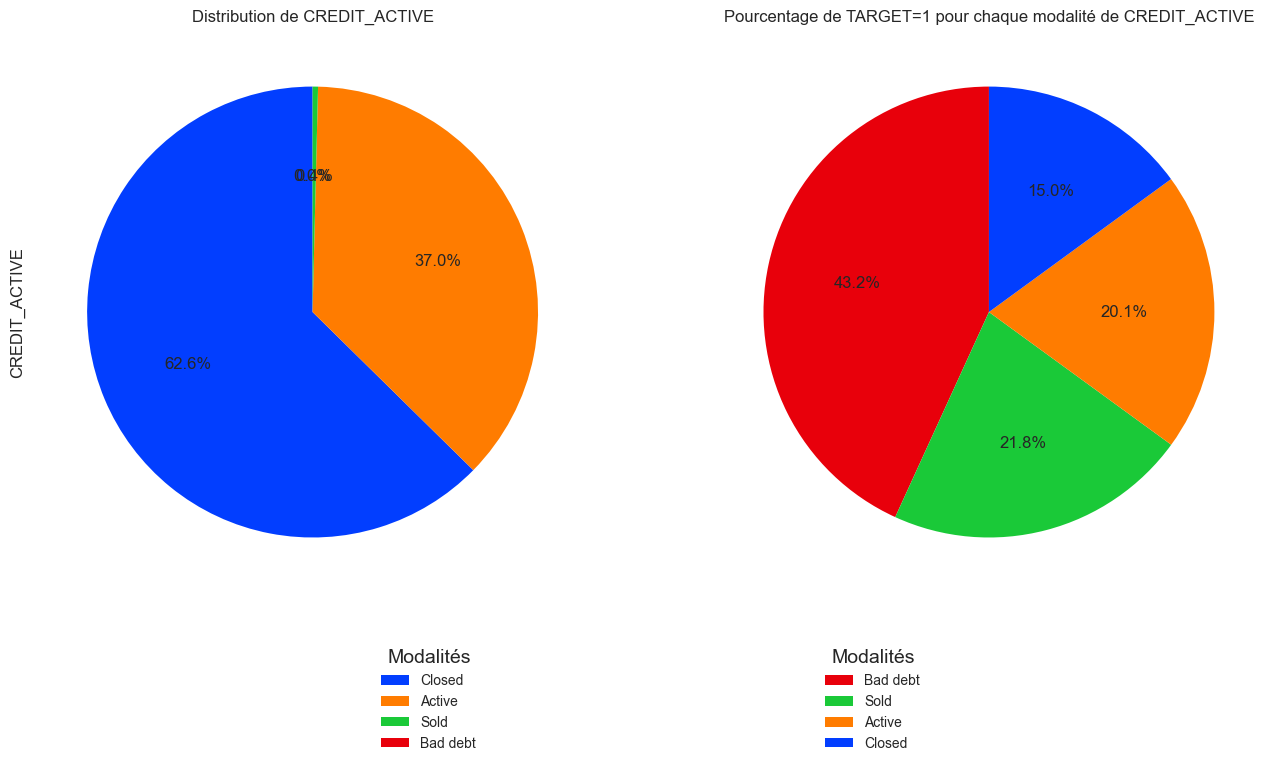

In [22]:
plot_pie_charts(application_bureau_train, 'CREDIT_ACTIVE')

#### bureau_balance data
Il s'agit ici des données mensuelles sur les crédits précédents dans le bureau. Chaque ligne représente un mois de crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.

In [23]:
bureau_balance

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0              5715448               0      C
1              5715448              -1      C
2              5715448              -2      C
3              5715448              -3      C
4              5715448              -4      C
...                ...             ...    ...
27299920       5041336             -47      X
27299921       5041336             -48      X
27299922       5041336             -49      X
27299923       5041336             -50      X
27299924       5041336             -51      X

[27299925 rows x 3 columns]

Statut du prêt du Credit Bureau au cours du mois (actif, fermé, DPD0-30, C signifie fermé, X signifie statut inconnu, 0 signifie pas de DPD, 1 signifie fait maximal au cours du mois entre 1-30, 2 signifie DPD 31-60, 5 signifie DPD 120+ ou vendu ou radié)

#### Previous application data
"previous_application" contient des informations sur toutes les demandes précédentes de crédit immobilier des clients qui ont des prêts dans l'échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

In [24]:
previous_application

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495      271877     Consumer loans     1730.430   
1           2802425      108129         Cash loans    25188.615   
2           2523466      122040         Cash loans    15060.735   
3           2819243      176158         Cash loans    47041.335   
4           1784265      202054         Cash loans    31924.395   
...             ...         ...                ...          ...   
1670209     2300464      352015     Consumer loans    14704.290   
1670210     2357031      334635     Consumer loans     6622.020   
1670211     2659632      249544     Consumer loans    11520.855   
1670212     2785582      400317         Cash loans    18821.520   
1670213     2418762      261212         Cash loans    16431.300   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
1               607500.0    679671.0               NaN         607500.0   
2               112500.0    136444.5               NaN         112500.0   
3               450000.0    470790.0               NaN         450000.0   
4               337500.0    404055.0               NaN         337500.0   
...                  ...         ...               ...              ...   
1670209         267295.5    311400.0               0.0         267295.5   
1670210          87750.0     64291.5           29250.0          87750.0   
1670211         105237.0    102523.5           10525.5         105237.0   
1670212         180000.0    191880.0               NaN         180000.0   
1670213         360000.0    360000.0               NaN         360000.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                         SATURDAY                       15   
1                         THURSDAY                       11   
2                          TUESDAY                       11   
3                           MONDAY                        7   
4                         THURSDAY                        9   
...                            ...                      ...   
1670209                  WEDNESDAY                       12   
1670210                    TUESDAY                       15   
1670211                     MONDAY                       12   
1670212                  WEDNESDAY                        9   
1670213                     SUNDAY                       10   

        FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
0                                 Y                       1   
1                                 Y                       1   
2                                 Y                       1   
3                                 Y                       1   
4                                 Y                       1   
...                             ...                     ...   
1670209                           Y                       1   
1670210                           Y                       1   
1670211                           Y                       1   
1670212                           Y                       1   
1670213                           Y                       1   

         RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0                 0.000000               0.182832                  0.867336   
1                      NaN                    NaN                       NaN   
2                      NaN                    NaN                       NaN   
3                      NaN                    NaN                       NaN   
4                      NaN                    NaN                       NaN   
...                    ...                    ...                       ...   
1670209           0.000000                    NaN                       NaN   
1670210           0.340554                    NaN                       NaN   
1670211           0.101401                    NaN                       NaN   

In [25]:
application_prev_train = app_train.merge(previous_application, 
                                                 left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

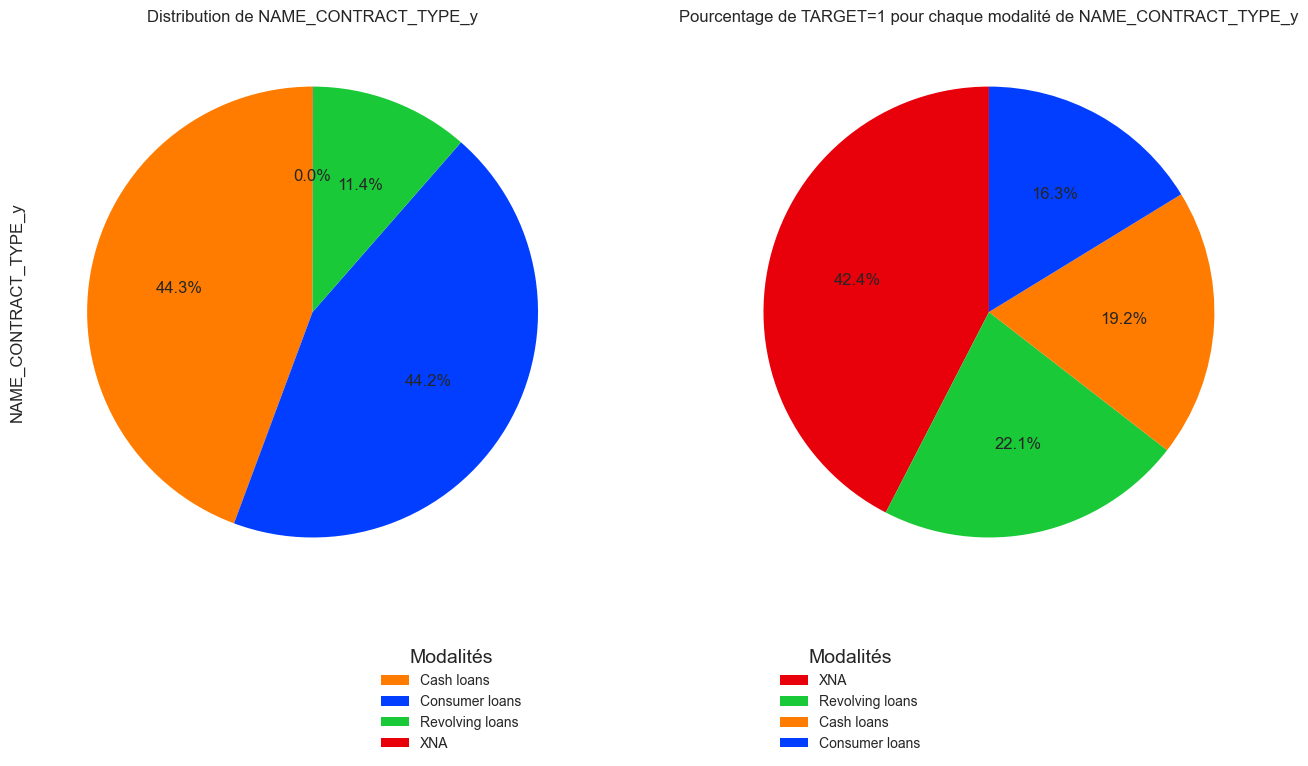

In [26]:
plot_pie_charts(application_prev_train, 'NAME_CONTRACT_TYPE_y')

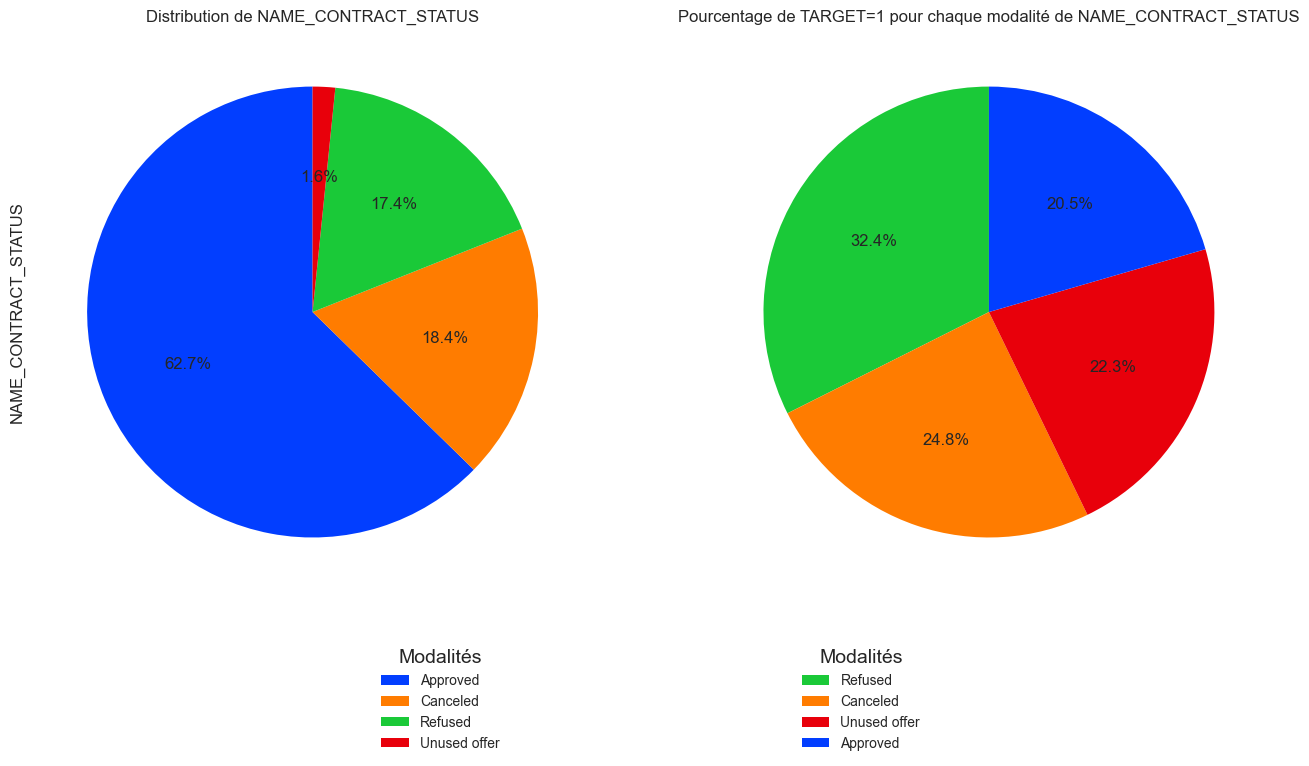

In [27]:
plot_pie_charts(application_prev_train, 'NAME_CONTRACT_STATUS')

## Merging et aggrégation des données

Afin d'accélérer la préparation des données je m'appuierai sur le kernel :"https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features".

J'ai pris la décision de rajouter plusieurs features qui me semblent pertinentes :   
-Le nombre de crédit actifs en cours : ACTIVE_CREDIT_COUNT  
-Le nombre de crédit clos : CLOSED_CREDIT_COUNT  
-Le nombre de précédentes demandes de crédits approuvées : APPROVED_CONTRACT_COUNT  
-Le nombre de précédentes demandes de crédits refusées : REFUSED_CONTRACT_COUNT

In [28]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    # Count closed credits
    active_count = bureau[bureau['CREDIT_ACTIVE_Active'] == 1].groupby('SK_ID_CURR').size().reset_index(name='ACTIVE_CREDIT_COUNT')
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    bureau_agg = bureau_agg.join(active_count.set_index('SK_ID_CURR'), on='SK_ID_CURR')
    del active, active_agg
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    # Count closed credits
    closed_count = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1].groupby('SK_ID_CURR').size().reset_index(name='CLOSED_CREDIT_COUNT')
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    bureau_agg = bureau_agg.join(closed_count.set_index('SK_ID_CURR'), on='SK_ID_CURR')
    del closed, closed_agg, bureau
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_count = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1].groupby('SK_ID_CURR').size().reset_index(name='APPROVED_CONTRACT_COUNT')
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    prev_agg = prev_agg.join(approved_count.set_index('SK_ID_CURR'), on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_count = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1].groupby('SK_ID_CURR').size().reset_index(name='REFUSED_CONTRACT_COUNT')
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    prev_agg = prev_agg.join(refused_count.set_index('SK_ID_CURR'), on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

data = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 118)
Process bureau and bureau_balance - done in 13s
Previous applications df shape: (338857, 251)
Process previous_applications - done in 14s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s
Installments payments df shape: (339587, 26)
Process installments payments - done in 17s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 10s


## Features engineering

### Constructions de nouvelles variables

Voici les variables qui ont été rajoutées par mes soins afin d'augmenter les performances du modèle :

In [29]:
def create_features(df):
    '''Création de variables prenant en compte les caractéristiques du client
    Args:
    - df: DataFrame.
    Returns:
    - df: DataFrame - le DataFrame avec les nouvelles variables.
    '''
    
    df['GOODS_PRICE_INCOME_PERCENT'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
    df['ACTIVE_CLOSED_CREDIT_RATIO'] = df['ACTIVE_CREDIT_COUNT'] / df['CLOSED_CREDIT_COUNT']
    df['APPROVED_REFUSED_CONTRACT_RATIO'] = df['APPROVED_CONTRACT_COUNT'] / df['REFUSED_CONTRACT_COUNT']
    return df
data = create_features(data)

In [30]:
data.shape

(356251, 805)

In [31]:
data.to_pickle("model_data.pkl")

## <div align=center> Partie 2 - Modelisation </div>

In [2]:
df = pd.read_pickle("model_data.pkl")

In [3]:
def split_dataset(df):
    '''Cette fonction prend un cadre de données en entrée et le divise en deux parties : les caractéristiques et la cible
    Args:
    - df: DataFrame - le DataFrame contenant les données à imputer.

    Returns:
    - X, y.
    '''
    feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR', 'index']]
    X = df[feats]
    y = df['TARGET']
    return X, y

def use_smote(X, y):
    ''' 
    Encode les variables catégorielles contenu dans le jeu de données

    Args:
    - X, y : les variables d'entrainement et la variable cible

    Returns:
    - X, y : les variables d'entrainement et la variable cible dont la classe minoritaire a été suréchantillonée.
    '''
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(X,y)
    return X_resampled, y_resampled


def get_weight(y_train):
    ''' 
    Calcul les poids de classe en fonction de la distribution des classes dans les données d'entraînement.

    Args:
    - y_train: un objet de type Series représentant la variable cible dans les données d'entraînement.
    
    Returns:
    - Un dictionnaire class_weights contenant les poids de classe pour chaque classe.
    '''
    # Calculer les poids de classe en fonction de la distribution des classes dans les données d'entraînement
    weights = np.array(1 / y_train.value_counts(normalize=True))
    class_weights = {0: weights[0], 1: weights[1]}
    return class_weights

def evaluation(model, X, y):
    '''
    Prend un modèle en entrée et évalue ses performances sur les données de validation croisée en utilisant un pipeline qui comprend un StandardScaler et, optionnellement, un SMOTE.

    Args:
    - model : modèle d'apprentissage automatique à évaluer
    - X : matrice de caractéristiques
    - y : vecteur cible

    Returns:
    -AUC : score AUC moyen de validation croisée
    -F1 : score F1 moyen de validation croisée
    -Precision : score de précision moyen de validation croisée
    -Recall : score de rappel moyen de validation croisée
    -Time : temps d'exécution moyen de validation croisée
    '''

    cv = StratifiedKFold(n_splits=5)
        
    # Effectuer une validation croisée avec le pipeline
    cv_results = cross_validate(model, X, y, cv= cv, scoring=['roc_auc', 'f1', 'precision', 'recall'], return_train_score=True, verbose=1)

    # Obtenir les scores moyens de validation croisée pour le test_set
    auc_mean_train = cv_results['train_roc_auc'].mean()
    f1_mean_train = cv_results['train_f1'].mean()
    precision_mean_train = cv_results['train_precision'].mean()
    recall_mean_train = cv_results['train_recall'].mean()
    
    # Obtenir les scores moyens de validation croisée pour le test_set
    auc_mean = cv_results['test_roc_auc'].mean()
    f1_mean = cv_results['test_f1'].mean()
    precision_mean = cv_results['test_precision'].mean()
    recall_mean = cv_results['test_recall'].mean()
    time_mean = cv_results['fit_time'].mean()
    
    print("\nTrain score :" ,"\nAUC:", auc_mean_train, "\nF1: ", f1_mean_train, "\nPrecision: ", precision_mean_train, "\nRecall: ", recall_mean_train,"\n")
    print("\nTest score :" ,"\nAUC:", auc_mean, "\nF1: ", f1_mean, "\nPrecision: ", precision_mean, "\nRecall: ", recall_mean, "\nTime: ", time_mean, "\n")

        
def plot_roc_auc(model, X_train, y_train, X_test, y_test):
    visualizer = ROCAUC(model, classes=["0", "1"], binary=True)
    visualizer.fit(X_train, y_train)        
    visualizer.score(X_test, y_test)       
    visualizer.show()
    
def plot_precision_recall(model, X_train, y_train, X_test, y_test):
    viz = PrecisionRecallCurve(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()
    
def plot_precision_recall_curve(model, threshold, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:,1]
    y_pred_threshold = np.where(y_pred_proba >= threshold, 1, 0)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    aps = average_precision_score(y_test, y_pred_proba)
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Avg. Precision Score = {:.3f})'.format(aps))
    plt.legend(loc="lower left")
    plt.show()
    
def predict_pipe(model, X_test, y_test):
    ''' 
    Prend un modèle en entrée et évalue 
    ses performances sur les données de test.

    Args:
    - model : modèle d'apprentissage automatique à évaluer
    
    Returns:
    -AUC : score AUC
    -F1 : score F1
    -Time : temps d'exécution du modèle
    -Matrice de confusion et courbe ROC.
    '''
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print("AUC:", auc, "\nF1: ", f1, "\nPrecision: ", precision, "\nRecall: ", recall)
    plot_confusion_matrix_roc(y_test, y_pred, y_pred_proba, auc)

    
def plot_confusion_matrix(y_true, y_pred):
    ''' 
    Prend en entrée les prédictions et les probabilités de prédiction d'un modèle, ainsi que les vraies étiquettes 
    (y_true) et la valeur de l'aire sous la courbe ROC (auc_value). Elle affiche ensuite une figure avec deux sous-graphes

    Args:
    - y_true, y_pred, y_pred_proba, auc_value.
    
    Returns:
    - Graphiques : Matrice de confusion et Courbe ROC.
    '''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    conf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"size": 15})
    plt.xlabel("Predictions", fontsize=16)
    plt.ylabel("Étiquettes réelles", fontsize=16)
    plt.title("Matrice de Confusion")

    plt.subplot(222)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_value = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.6f' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.legend(fontsize=20)
    plt.title("Area Under the Curve")

    plt.show()
def plot_confusion_matrix_roc(y_true, y_pred, y_pred_proba, auc_value):
    ''' 
    Prend en entrée les prédictions et les probabilités de prédiction d'un modèle, ainsi que les vraies étiquettes 
    (y_true) et la valeur de l'aire sous la courbe ROC (auc_value). Elle affiche ensuite une figure avec deux sous-graphes

    Args:
    - y_true, y_pred, y_pred_proba, auc_value.
    
    Returns:
    - Graphiques : Matrice de confusion et Courbe ROC.
    '''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    conf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"size": 15})
    plt.xlabel("Predictions", fontsize=16)
    plt.ylabel("Étiquettes réelles", fontsize=16)
    plt.title("Matrice de Confusion")

    plt.subplot(222)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_value = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.6f' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.legend(fontsize=20)
    plt.title("Area Under the Curve")

    plt.show()

In [4]:
def prepare_data(df):
    data = df.copy()
    feats = [f for f in data.columns if f not in ['index','SK_ID_CURR']]
    data = data[feats]
    data = data.reset_index(drop=True)
    data = data[data['TARGET'].notnull()]
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    return data
data = prepare_data(df)
print(data.shape)

(307507, 803)


In [5]:
X, y = split_dataset(data)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [28]:
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                  MinMaxScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'))
preprocessor= make_column_transformer((numerical_pipeline, make_column_selector(dtype_include=['int64', 'float64'])),
                       (categorical_pipeline, make_column_selector(dtype_include=object)))

In [38]:
dummy = DummyClassifier(strategy='stratified', random_state=0)
lr = LogisticRegression(random_state=0)
ridge = RidgeClassifier(random_state=0)

In [7]:
class_weight = get_weight(y)
print(class_weight)

{0: 1.0878195286576435, 1: 12.386988922457201}


### Baseline model : Dummy Classifier

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished



Train score : 
AUC: 0.4996950339688754 
F1:  0.08028158390949089 
Precision:  0.08017072558373087 
Recall:  0.08039274924471299 


Test score : 
AUC: 0.5013382854334605 
F1:  0.08275443037974684 
Precision:  0.08321792260692465 
Recall:  0.08229607250755286 
Time:  18.79278931617737 



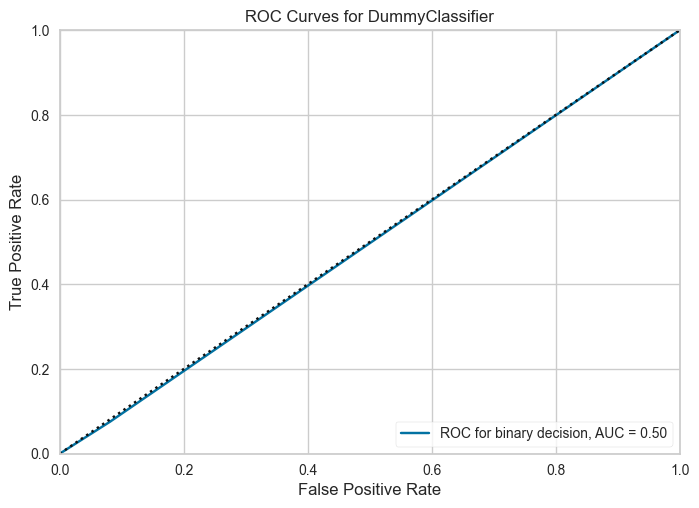

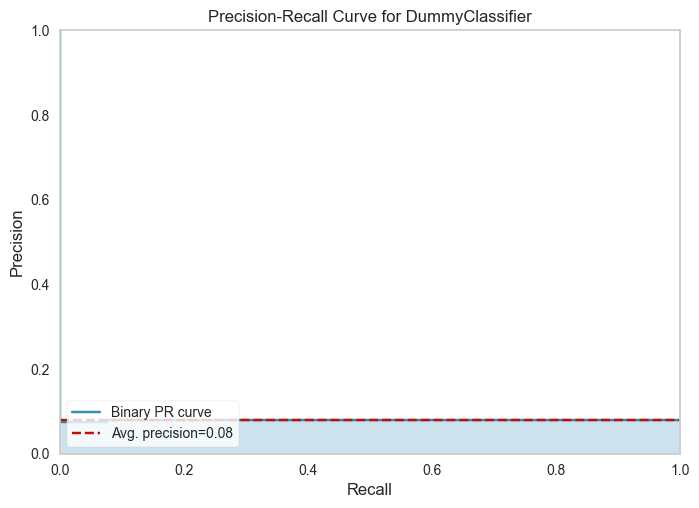

In [40]:
dummy_pipeline = make_pipeline(preprocessor, dummy)
evaluation(dummy_pipeline, X, y)
dummy_pipeline.fit(X_train, y_train)
plot_roc_auc(dummy_pipeline, X_train, y_train, X_test, y_test)
plot_precision_recall(dummy_pipeline, X_train, y_train, X_test, y_test)

### Regression Logistique

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min finished



Train score : 
AUC: 0.7658970185879218 
F1:  0.048381580193111916 
Precision:  0.5194466891744024 
Recall:  0.025377643504531727 


Test score : 
AUC: 0.7625385091228619 
F1:  0.047927272235027726 
Precision:  0.5153637839979206 
Recall:  0.025135951661631423 
Time:  33.742088317871094 



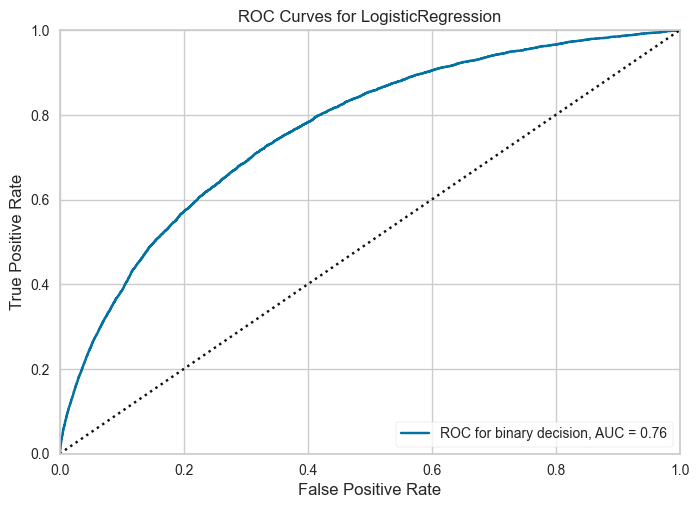

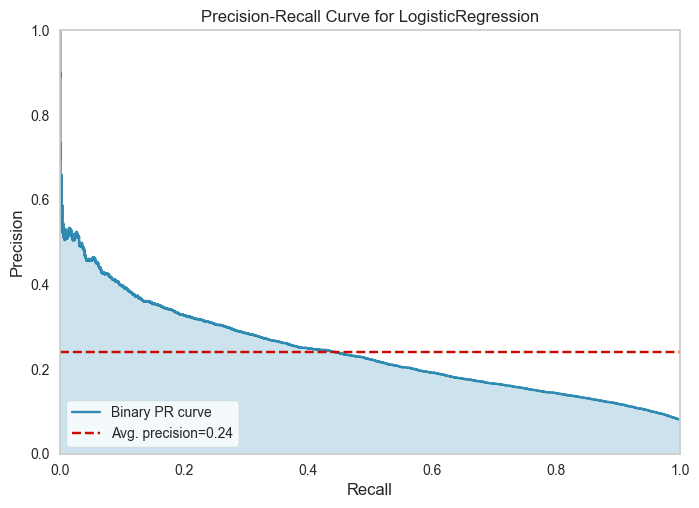

In [41]:
lr_pipeline = make_pipeline(preprocessor, lr)
evaluation(lr_pipeline, X, y)
lr_pipeline.fit(X_train, y_train)
plot_roc_auc(lr_pipeline, X_train, y_train, X_test, y_test)
plot_precision_recall(lr_pipeline, X_train, y_train, X_test, y_test)

#### Using class_weight for imbalanced classification

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min finished



Train score : 
AUC: 0.7680970010358712 
F1:  0.27469537086258633 
Precision:  0.17101002366394547 
Recall:  0.6977744209466263 


Test score : 
AUC: 0.7637811218360577 
F1:  0.27190242353511956 
Precision:  0.1692787175307821 
Recall:  0.6905941591137965 
Time:  33.19366807937622 



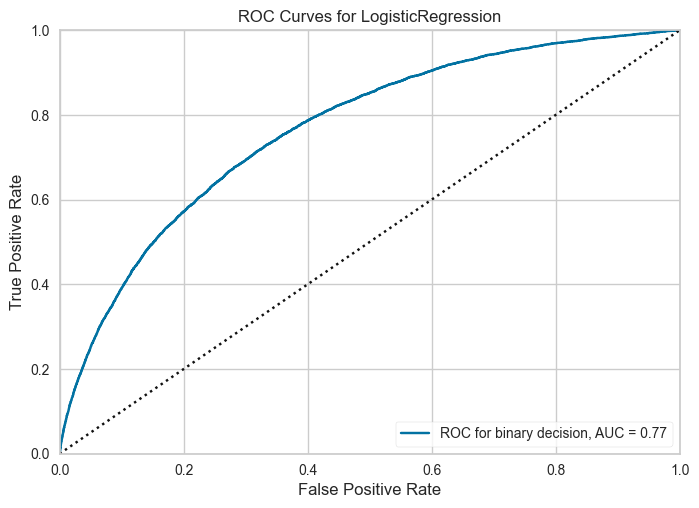

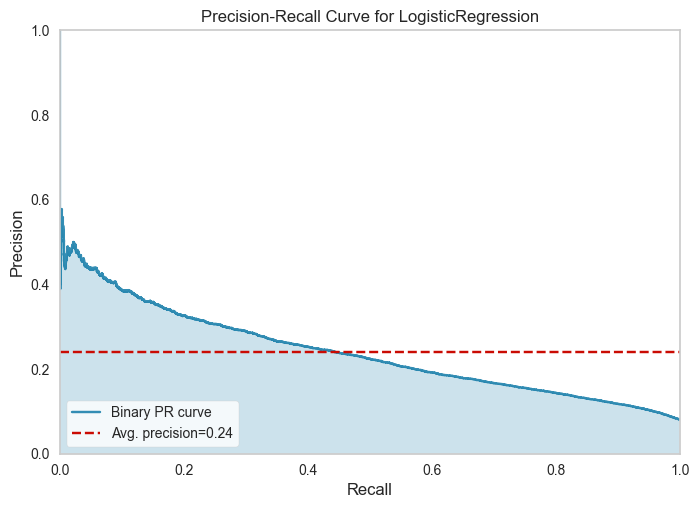

In [42]:
lr_weight_pipeline = make_pipeline(preprocessor, LogisticRegression(random_state=0, class_weight=class_weight))
evaluation(lr_weight_pipeline, X, y)
lr_weight_pipeline.fit(X_train, y_train)
plot_roc_auc(lr_weight_pipeline, X_train, y_train, X_test, y_test)
plot_precision_recall(lr_weight_pipeline, X_train, y_train, X_test, y_test)

#### Using SMOTE for imbalanced Classification

In [43]:
def plot_counter(counter):
    values, counts = zip(*counter.items())
    plt.hist(values, weights=counts)
    plt.title("Distribution de TARGET")
    plt.show()

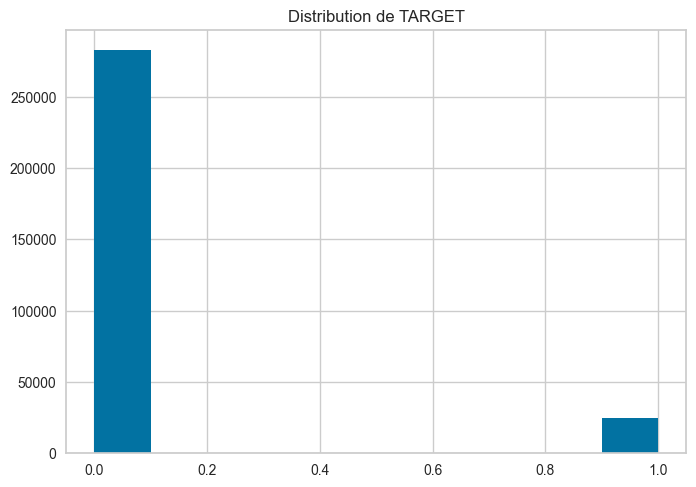

In [44]:
plot_counter(Counter(y))

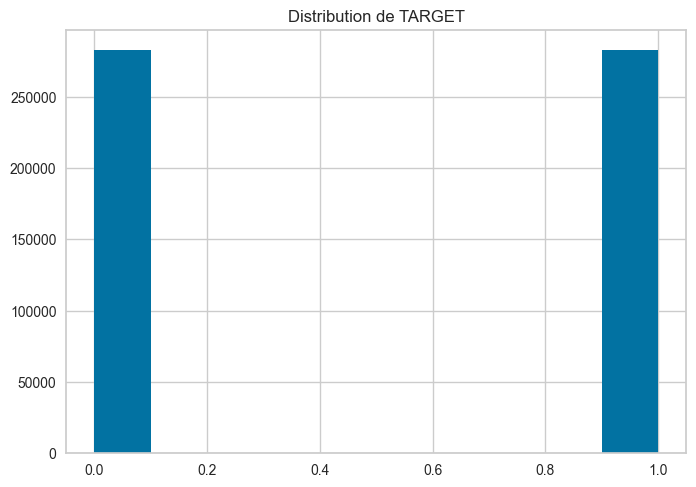

In [45]:
X_transformed = preprocessor.fit_transform(X)
X_resampled, y_resampled = use_smote(X_transformed, y)
plot_counter(Counter(y_resampled))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.1min finished



Train score : 
AUC: 0.7757863689258377 
F1:  0.28316497193999407 
Precision:  0.17747405147470402 
Recall:  0.7000906344410877 


Test score : 
AUC: 0.7681967779961018 
F1:  0.27883248458961035 
Precision:  0.17478293744932133 
Recall:  0.6890231621349446 
Time:  51.96043448448181 



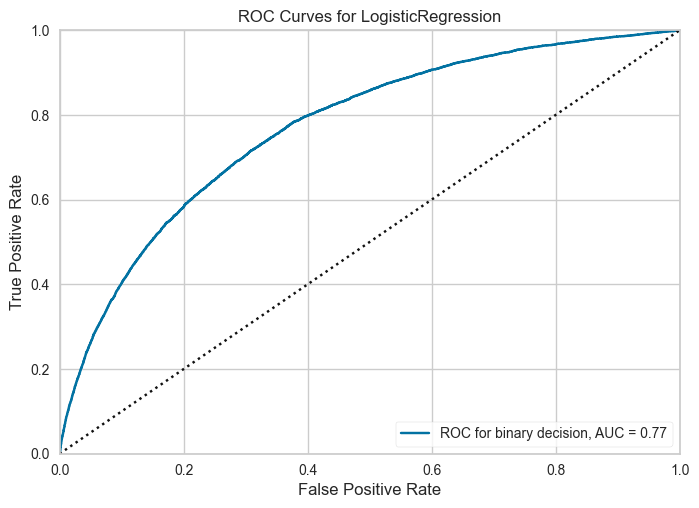

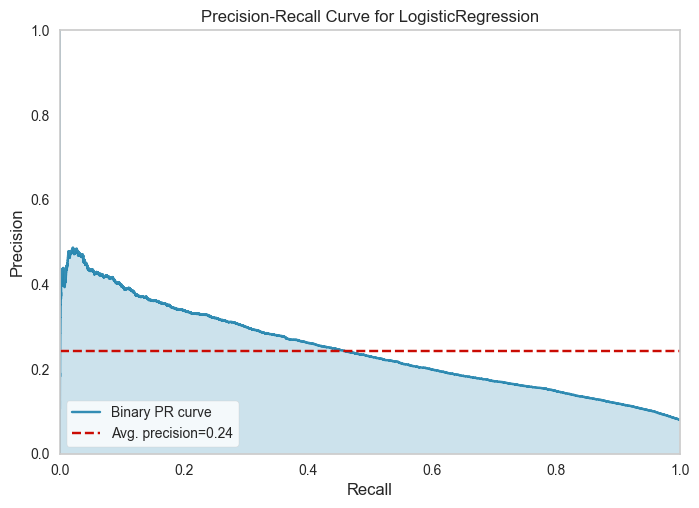

In [46]:
lr_smote_pipeline = imbPipeline(steps=[
    ('cleaning', ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), make_column_selector(dtype_include=['int64', 'float64'])),
        ('cat', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=object))
    ])),
    ('smote', SMOTE(sampling_strategy='minority')),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=0))
])

evaluation(lr_smote_pipeline, X, y)
lr_smote_pipeline.fit(X_train, y_train)
plot_roc_auc(lr_smote_pipeline, X_train, y_train, X_test, y_test)
plot_precision_recall(lr_smote_pipeline, X_train, y_train, X_test, y_test)

### Ridge Classifier - class weight

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished



Train score : 
AUC: 0.7767161874470372 
F1:  0.2818912747171254 
Precision:  0.17598980888597496 
Recall:  0.7078247734138973 


Test score : 
AUC: 0.7700569793748827 
F1:  0.277925170137893 
Precision:  0.1735459819153659 
Recall:  0.697361530715005 
Time:  20.43011918067932 



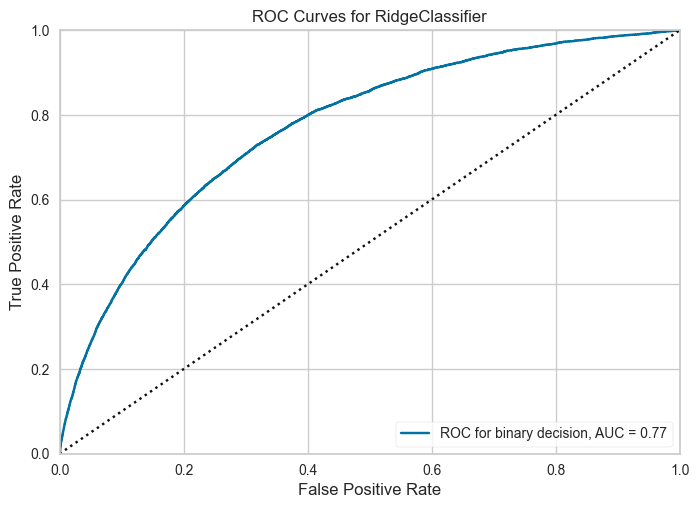

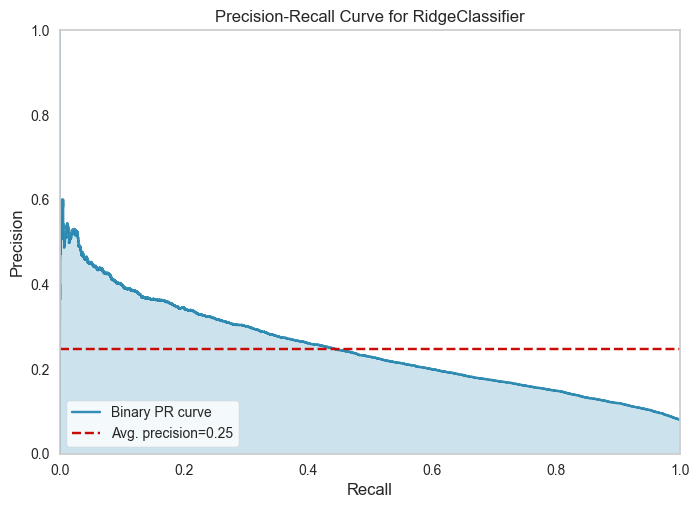

In [47]:
ridge_pipeline = make_pipeline(preprocessor, RidgeClassifier(random_state=0, class_weight=class_weight))
evaluation(ridge_pipeline, X, y)
ridge_pipeline.fit(X_train, y_train)
plot_roc_auc(ridge_pipeline, X_train, y_train, X_test, y_test)
plot_precision_recall(ridge_pipeline, X_train, y_train, X_test, y_test)

### Comparatif de LGBM Classifier avec class weight et avec SMOTE

##### LGBM Classifier avec class weight

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.7min finished



Train score : 
AUC: 0.8312884800837997 
F1:  0.31034804543012784 
Precision:  0.19279522864707738 
Recall:  0.7952165156092649 


Test score : 
AUC: 0.7818894792668062 
F1:  0.28113133614170066 
Precision:  0.17461766080070226 
Recall:  0.7208459214501509 
Time:  33.76006789207459 



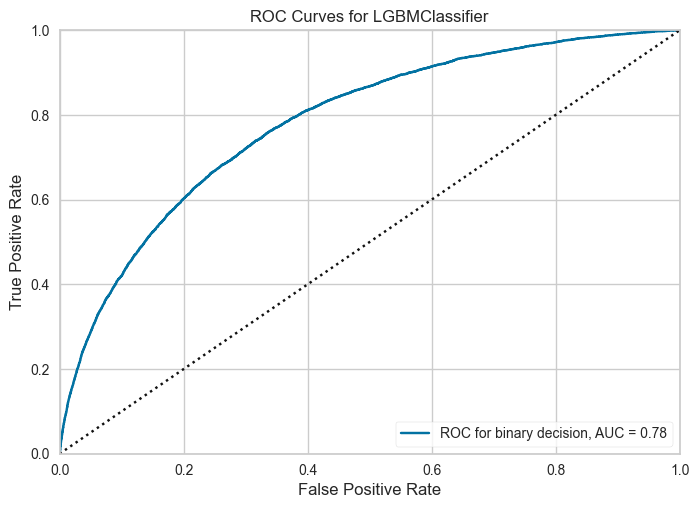

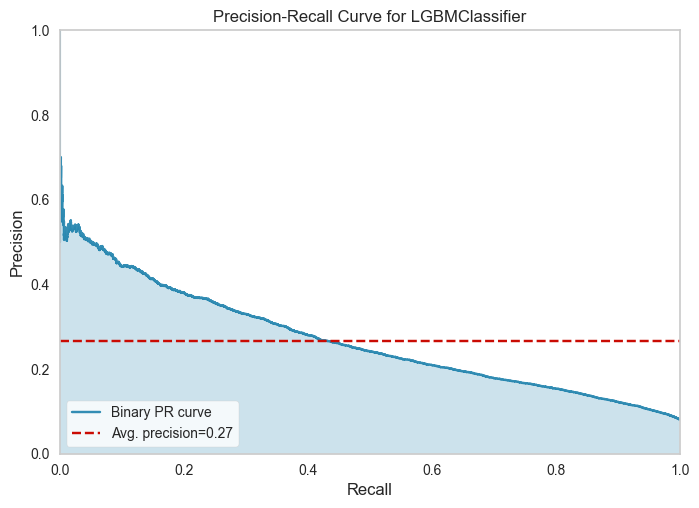

In [48]:
lgbm_pipeline = imbPipeline(steps=[
    ('cleaning', ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), make_column_selector(dtype_include=['int64', 'float64'])),
        ('cat', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=object))
    ])),
    ('scaler', StandardScaler()),
    ('lr', LGBMClassifier(objective="binary", random_state=0, scale_pos_weight=class_weight[1]))
])
evaluation(lgbm_pipeline, X, y)
lgbm_pipeline.fit(X_train, y_train)
plot_roc_auc(lgbm_pipeline, X_train, y_train, X_test, y_test)
plot_precision_recall(lgbm_pipeline, X_train, y_train, X_test, y_test)

##### LGBM Classifier avec SMOTE

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.3min finished



Train score : 
AUC: 0.7977436472045382 
F1:  0.054859422220139384 
Precision:  0.6651097001035275 
Recall:  0.028610271903323263 


Test score : 
AUC: 0.7712189195172348 
F1:  0.04416480771769631 
Precision:  0.5541445192245787 
Recall:  0.023001007049345417 
Time:  52.615262508392334 



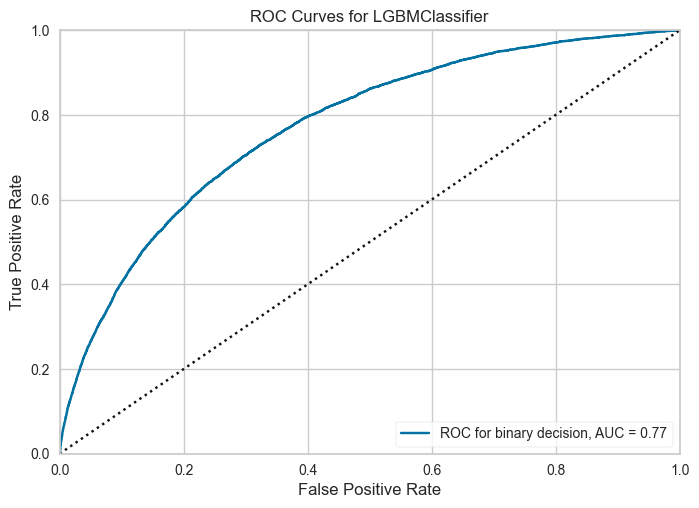

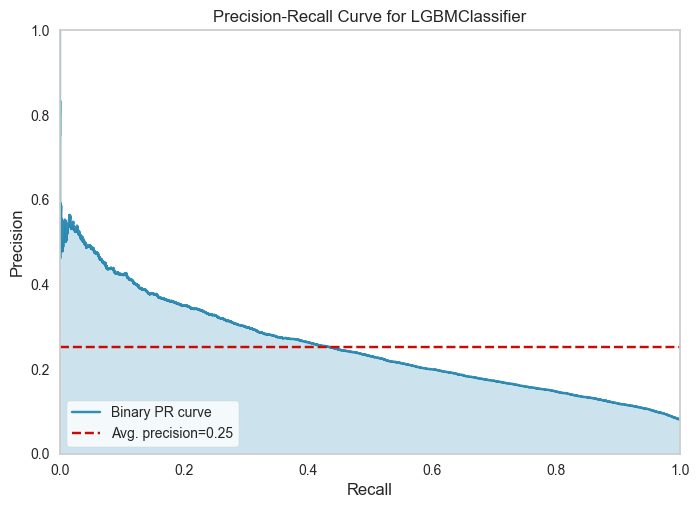

In [49]:
lgbm_smote_pipeline = imbPipeline(steps=[
    ('cleaning', ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), make_column_selector(dtype_include=['int64', 'float64'])),
        ('cat', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=object))
    ])),
    ('smote', SMOTE(sampling_strategy='minority', random_state=0)),
    ('scaler', MinMaxScaler()),
    ('lr', LGBMClassifier(objective="binary", random_state=0))
])
evaluation(lgbm_smote_pipeline, X, y)
lgbm_smote_pipeline.fit(X_train, y_train)
plot_roc_auc(lgbm_smote_pipeline, X_train, y_train, X_test, y_test)
plot_precision_recall(lgbm_smote_pipeline, X_train, y_train, X_test, y_test)

### Feature Selection

Nous avons un jeu de données qui contient plus de 800 features différentes, nous allons tenter de faire une sélection de nos variables.  
Pour ce faire nous allons entrainer notre modèle ayant obtenu les meilleurs résultats (LGBMClassifier) plusieurs fois sur nos données (avec attribution de scale_pos_weight au modèle) et après chaque entrainement, des features seront éliminées sur la base des coefficients les plus faibles de l'estimateur.  
Pour l'estimateur, nous allons utiliser la métrique 'average_precision' qui est souvent utilisée pour des tâches de classification binaire où les classes sont déséquilibrées.

### RFECV : Selection récursive des features

In [42]:
df = prepare_data(df)
X, y = split_dataset(df)
X_scaled = MinMaxScaler().fit_transform(X)
model = LGBMClassifier(objective='binary', random_state=0, scale_pos_weight=class_weight[1])

In [43]:
rfecv = RFECV(estimator=model, 
              step=20, 
              cv=StratifiedKFold(5), 
              scoring='average_precision', 
              verbose=2,
              n_jobs=6)
rfecv.fit(X_scaled, y)
print("Optimal number of features : %d" % rfecv.n_features_)
best_features = rfecv.get_support(indices=True)
best_features = np.array(X.columns)[best_features]
best_features

Fitting estimator with 802 features.
Fitting estimator with 782 features.
Fitting estimator with 762 features.
Fitting estimator with 742 features.
Fitting estimator with 722 features.
Fitting estimator with 702 features.
Fitting estimator with 682 features.
Fitting estimator with 662 features.
Fitting estimator with 642 features.
Fitting estimator with 622 features.
Fitting estimator with 602 features.
Fitting estimator with 582 features.
Fitting estimator with 562 features.
Fitting estimator with 542 features.
Fitting estimator with 522 features.
Fitting estimator with 502 features.
Fitting estimator with 482 features.
Fitting estimator with 462 features.
Fitting estimator with 442 features.
Fitting estimator with 422 features.
Fitting estimator with 402 features.
Fitting estimator with 382 features.
Fitting estimator with 362 features.
Fitting estimator with 342 features.
Fitting estimator with 322 features.
Fitting estimator with 302 features.
Fitting estimator with 282 features.
F

array(['CODE_GENDER', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'FLOORSMAX_AVG', 'APARTMENTS_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MEDI', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_18', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'NAME_CONTRACT_TYPE_Cash loans', 'NAME_INCOME_TYPE_State servant',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Married', 'OCCUPATION_TYPE_Core staff',
       'ORGANIZATION_TYPE_Self-employe

On remarque que RFECV a retenu plusieurs des variables que l'on a ajouté au jeu de données, à savoir :  
-GOODS_PRICE_INCOME_PERCENT  
-ACTIVE_CLOSED_CREDIT_RATIO  
-ACTIVE_CREDIT_COUNT  
-APPROVED_REFUSED_CONTRACT_RATIO

In [44]:
reduced_data = df[best_features]
reduced_data['TARGET'] = y
reduced_data.to_pickle("reduced_data.pkl")

### Application de la problématique métier

-`Faux positifs (FP)` : Client qui est considéré à tort comme un mauvais payeur. (Etiquette : 1, Réel : 0)  
-`Faux négatifs (FN)` : Client qui est considéré à tort comme un bon payeur. (Etiquette : 0, Réel : 1)  
-`Precision` : Rapport entre le nombre de vrais positifs correctement classés et le nombre total d'observations classées comme positives.   
-`Recall` : Rapport entre le nombre de vrais positifs correctement classés et le nombre total de vrais positifs  
-`F1 score` : Mesure de performance qui combine la précision et le rappel d'un modèle de classification binaire. Il est calculé comme la moyenne harmonique entre la précision et le rappel.  
-`beta` : Le paramètre beta est utilisé pour contrôler l'importance accordée à la précision et au rappel dans la mesure de performance. Plus beta est grand, plus la métrique accorde de l'importance au rappel plutôt qu'à la précision.


Après l'enonciation de toutes ces définitions, il s'agira maintenant de savoir qu'est ce qu'il convient de faire afin de minimiser les pertes financières de l'entreprise Prêt à dépenser.  
Dans notre cas la maximisation du Rappel (Recall ou Sensibilité) revient à minimiser le nombre de Faux négatifs (Perte financières si le crédit est accordé et se transforme en défaut de paiement).  
Il sera donc judicieux de choisir un beta supérieur à 1 pour faire varier le poids donné au rappel. En effet, plus beta est élevé, plus le poids donné au rappel est important.  
Afin de contrer l'oversampling du jeu de données, nous utiliserons à l'avenir la méthode class_weight à la place de SMOTE car elle semble réduire les faux négatifs.

In [45]:
loaded_df = pd.read_pickle("reduced_data.pkl")
loaded_df.shape

(307507, 163)

In [46]:
data = prepare_data(loaded_df)

In [47]:
X, y = split_dataset(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X.shape, y.shape)

(307507, 162) (307507,)


In [48]:
model = LGBMClassifier(objective='binary', scale_pos_weight=class_weight[1], random_state=0)
steps= [['scaler', MinMaxScaler()],
        ['classifier', model]]
pipeline = Pipeline(steps=steps)

#### Fbeta score

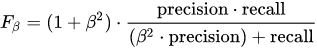

Afin d'observer si la métrique que nous allons choisir pénalise bien les Faux Négatifs, nous pouvons réaliser quelques tests et observer la réaction de f_beta2 score

In [49]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [500, 300, 40, 0]
test_3 = [400, 300, 70, 50]
test_4 = [400, 300, 50, 70]
test_5 = [350, 250, 80, 120]
test_6 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5, test_6]

In [50]:
def test_beta_score(predictions_success: list) -> int:
    ''' 
    Calcul le F-beta score pour un ensemble de prédictions.

    Args:
    - predictions_success: Liste de 4 éléments représentant le nombre de vrais positifs, vrais négatifs, faux positifs et 
    faux négatifs, respectivement.

    Returns:
    - results: fbeta_score - F-beta score pour beta = 3.
    '''
    tp, tn, fp, fn = predictions_success
    beta = 2
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) 
    fbeta_score = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)  
    return fbeta_score

for i, t in enumerate(tests):
    print("Test", i, ":", t)
    print("Score :", test_beta_score(t))

Test 0 : [500, 300, 10, 30]
Score : 0.9505703422053232
Test 1 : [500, 300, 30, 10]
Score : 0.9727626459143969
Test 2 : [500, 300, 40, 0]
Score : 0.9842519685039369
Test 3 : [400, 300, 70, 50]
Score : 0.8810572687224669
Test 4 : [400, 300, 50, 70]
Score : 0.8583690987124464
Test 5 : [350, 250, 80, 120]
Score : 0.7575757575757577
Test 6 : [350, 250, 180, 90]
Score : 0.7641921397379912


In [51]:
fbeta2_scorer = make_scorer(fbeta_score, beta=2)
scores = cross_validate(pipeline, X, y, cv=StratifiedKFold(5), scoring =fbeta2_scorer)
print("Scores: ", scores)

Scores:  {'fit_time': array([4.95320058, 5.06498051, 5.52675104, 5.00881124, 5.07423353]), 'score_time': array([0.19554114, 0.19104338, 0.22905087, 0.18603778, 0.1965394 ]), 'test_score': array([0.44880385, 0.45184143, 0.44402557, 0.44358859, 0.44521484])}


#### Métrique personnalisée sur la base d'une combinaison linéaire des faux négatifs et des faux positifs

In [52]:
def custom_metric(y_true, y_pred):
    ''' 
    Définit une métrique personnalisée qui est une combinaison linéaire des FN et des FP avec plus de poids accordé aux FN

    Args:
    - y_true, y_pred: Données de test et prédiction du modèle

    Returns:
    - results: custom_score - Métrique personnalisée.
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    score = 10*fn + fp  
    return score

def test_custom_cost(predictions_success: list) -> int:
    ''' 
    Définit une métrique personnalisée qui est une combinaison linéaire des FN et des FP avec plus de poids accordé aux FN

    Args:
    - predictions_success: Liste de 4 éléments représentant le nombre de vrais positifs, vrais négatifs, faux positifs et 
    faux négatifs, respectivement.

    Returns:
    - results: score - Score de la métrique personnalisée.
    '''
    tp, tn, fp, fn = predictions_success
    score = 10*fn + fp  
    return score

for i, t in enumerate(tests): 
    print("Test", i, ":", t)
    print("Score :", test_custom_cost(t))

Test 0 : [500, 300, 10, 30]
Score : 310
Test 1 : [500, 300, 30, 10]
Score : 130
Test 2 : [500, 300, 40, 0]
Score : 40
Test 3 : [400, 300, 70, 50]
Score : 570
Test 4 : [400, 300, 50, 70]
Score : 750
Test 5 : [350, 250, 80, 120]
Score : 1280
Test 6 : [350, 250, 180, 90]
Score : 1080


In [53]:
custom_scorer = make_scorer(custom_metric, greater_is_better=False)

Ce score sera donc à minimiser pendant l'entrainement du modèle sur une grille de recherche.

In [54]:
scores = cross_validate(pipeline, X, y, cv=StratifiedKFold(5), scoring=custom_scorer)
print("Scores: ", scores)

Scores:  {'fit_time': array([4.9192183 , 4.96575761, 5.27634501, 4.96529603, 5.15877151]), 'score_time': array([0.20104241, 0.24555802, 0.20654225, 0.21554351, 0.23705125]), 'test_score': array([-30299, -30031, -30717, -30757, -30616])}


Nous allons utiliser notre combinaison linéaire de 10FN + FP pour l'optimisation des hyperparamètres de notre modèle

### Optimisation des hyper-paramètres

#### Randomized Search

In [66]:
cross_val = StratifiedKFold(n_splits=5)
model=LGBMClassifier(objective='binary', random_state=0, scale_pos_weight= class_weight[1])
scaler = make_column_transformer((MinMaxScaler(), make_column_selector(dtype_include=np.number)))
search_pipeline = make_pipeline(scaler, model)

gridParams = {
    'lgbmclassifier__learning_rate': [0.01, 0.04],
    'lgbmclassifier__n_estimators': [500, 1000],
    'lgbmclassifier__boosting_type': ['gbdt', 'goss'],
    'lgbmclassifier__num_leaves': [31, 62, 80],
    'lgbmclassifier__max_depth': [7, 10, 20], # large num_leaves helps improve accuracy but might lead to over-fitting
    'lgbmclassifier__reg_alpha' : [0, 0.5, 1, 1.5],
    'lgbmclassifier__reg_lambda' : [0, 0.5, 1, 1.5],
    'lgbmclassifier__subsample': [0.85, 1]
    }

random_search = RandomizedSearchCV(search_pipeline, param_distributions=gridParams, cv=cross_val, n_iter=50, scoring=custom_scorer, n_jobs=6, verbose=2)
random_search.fit(X_train, y_train)
print('Meilleur score:', random_search.best_score_)
new_params = {k.split('__')[1]: v for k, v in random_search.best_params_.items()}
print(new_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleur score: -20993.2
{'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.04, 'boosting_type': 'goss'}


## Modèle Final
Observons maitenant le modèle entrainé sur notre métrique personnalisée

AUC: 0.790176617633283 
F1:  0.2968242563586722 
Precision:  0.18872889408668958 
Recall:  0.6947396744248621


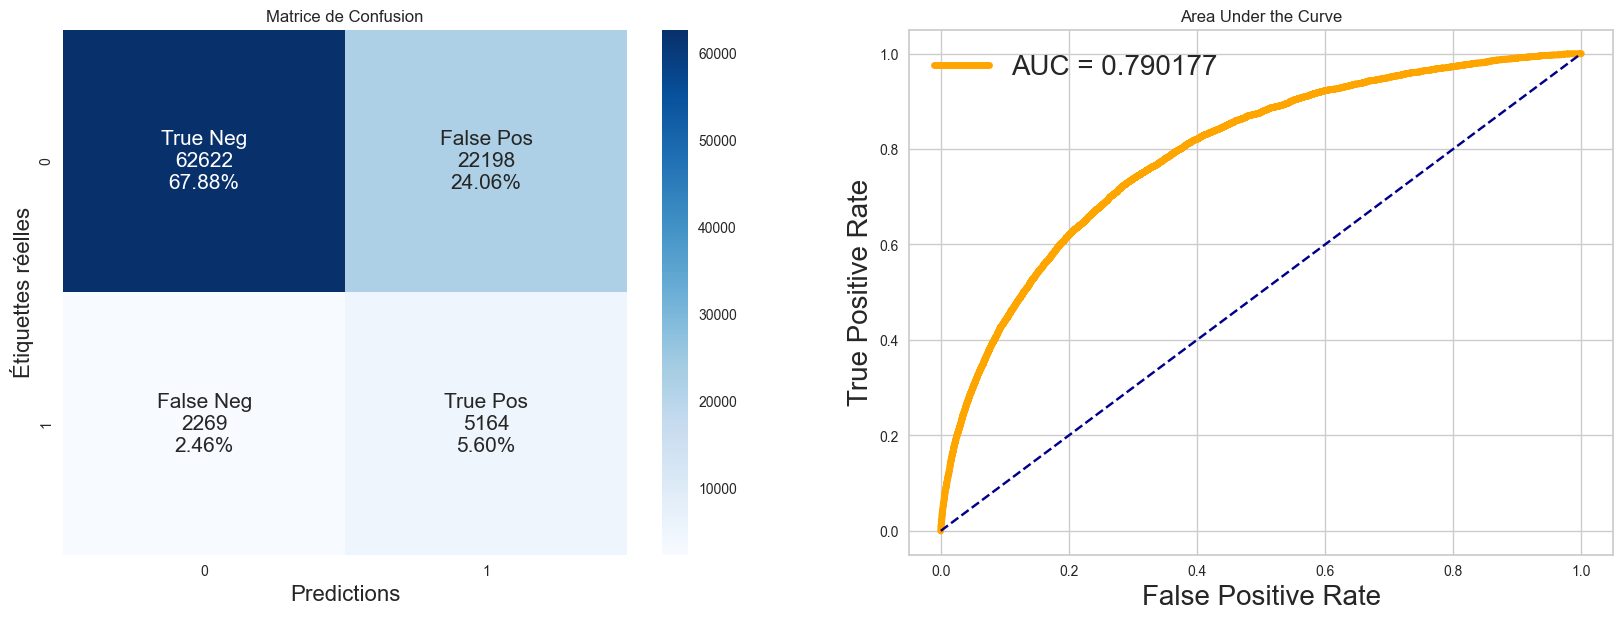

In [67]:
predict_pipe(random_search, X_test, y_test)

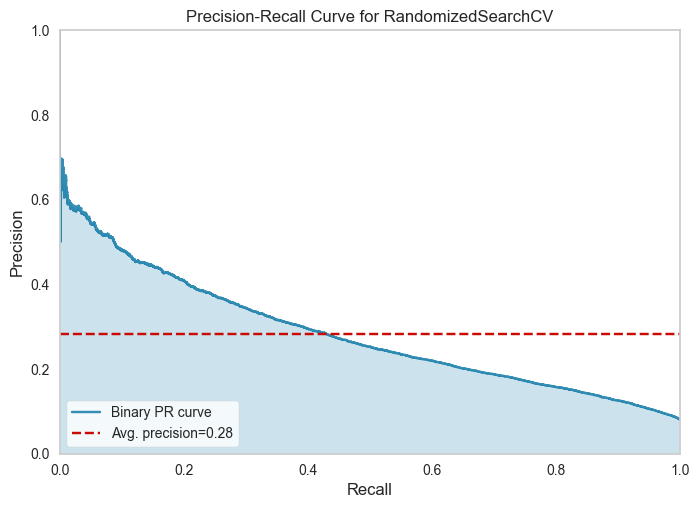

In [85]:
plot_precision_recall(random_search, X_train, y_train, X_test, y_test)

#### Choix seuil de probabilité
**Remarque**: Une autre façon d'influencer le nombre de faux positifs et faux négatifs est le seuil de probabilité.
En effet, par défault, la probabilité qu'une prédiction soit attribuée à une classe est basée sur le seuil médian 0.5. Si l'on modifie ce seuil, alors cela aura une influence sur les prédictions du modèle.

In [71]:
def compare_threshold_variance(model, thresholds, X_test, y_test):
    ''' 
    Prend en entrée un modèle entrainé, une liste de seuils et retourne un dictionnaire contenant les scores de la métrique 
    personnalisée custom_metric_2 pour chaque seuil donné. 
    Elle sélectionne ensuite le seuil ayant le score le plus bas et le retourne.

    Args:
    - model, thresholds: Modèle entrainé et une liste de seuils.

    Returns:
    - results_sorted: Seuil pour lequel notre métrique personnalisé est la plus petite (10*FN + FP).
    '''
    y_pred_proba = model.predict_proba(X_test)[:,1]
    results = []
    for threshold in thresholds:
        y_pred_threshold = np.where(y_pred_proba >= threshold, 1, 0)
        f1 = f1_score(y_test, y_pred_threshold)
        custom_score = custom_metric(y_test, y_pred_threshold)
#         print("Seuil de probabilité", threshold,"\nCustom métrique" ,custom_score)
        results.append({'threshold': threshold, 'custom_score': custom_score})
    # Récupération du seuil avec le score le plus bas
    results_sorted = sorted(results, key=lambda x: x['custom_score'])
    best_threshold = results_sorted[0]['threshold']
    print('Best threshold:', best_threshold)
    return best_threshold

In [72]:
thresholds = np.linspace(0, 1, 101)
best_threshold = compare_threshold_variance(random_search, thresholds, X_test, y_test)

Best threshold: 0.48


Recall:  0.7204358939862774 
Precision:  0.18239100817438691 
F1:  0.2910879786915989 
Auc : 0.790176617633283


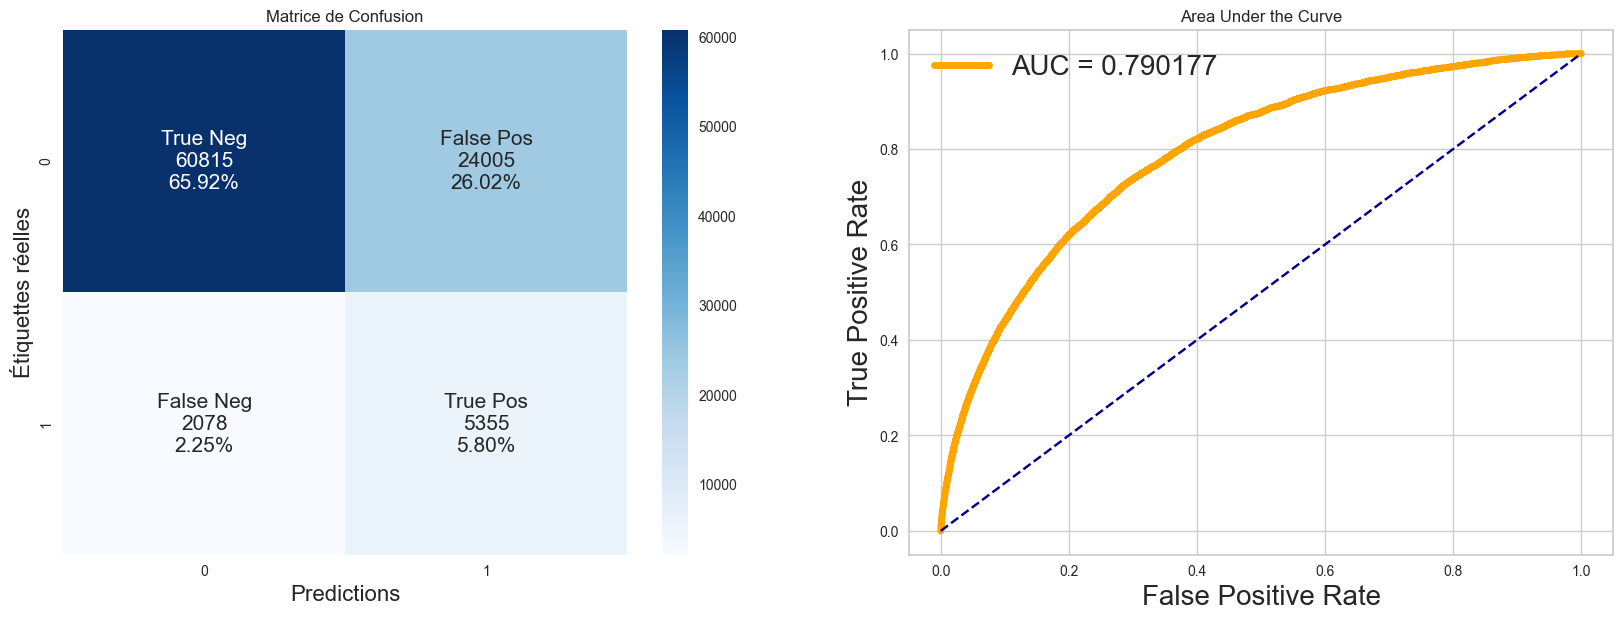

In [73]:
def evaluation_threshold(model, threshold, X_test, y_test):
    ''' 
    Evalue les performances d'un modèle de classification binaire en utilisant un seuil de probabilité donné.
    Args:
    - model, thresholds: Modèle entrainé et un seuil de probabilité.

    Returns:
    - Graphiques (matrice_confusion et courbe ROC), score f1
    '''
    y_pred_proba = model.predict_proba(X_test)[:,1]
    y_pred_threshold = np.where(y_pred_proba >= threshold, 1, 0)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred_threshold)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    print("Recall: ", recall, "\nPrecision: ", precision,"\nF1: ", f1, "\nAuc :", auc)
    plot_confusion_matrix_roc(y_test, y_pred_threshold, y_pred_proba, auc)
    
evaluation_threshold(random_search, best_threshold, X_test, y_test)

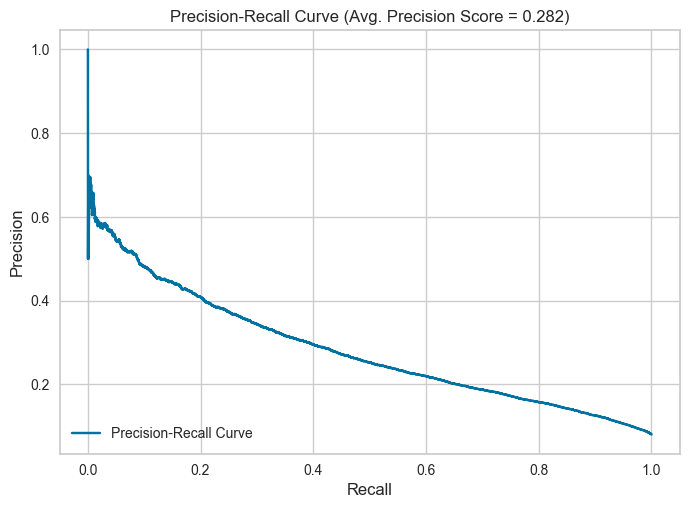

In [74]:
plot_precision_recall_curve(random_search, best_threshold, X_test, y_test)

### Courbe d'apprentissage

In [83]:
final_model = LGBMClassifier(objective='binary', random_state=0, scale_pos_weight=class_weight[1], **new_params)
final_pipeline = make_pipeline(scaler, final_model)
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A959304D60>)])),
                ('lgbmclassifier',
                 LGBMClassifier(boosting_type='goss', learning_rate=0.04,
                                max_depth=20, n_estimators=500,
                                objective='binary', random_state=0, reg_alpha=0,
                                reg_lambda=1,
                                scale_pos_weight=12.386988922457201,
                                subsample=1))])

[ 49201  98402 147603 196804 246005]


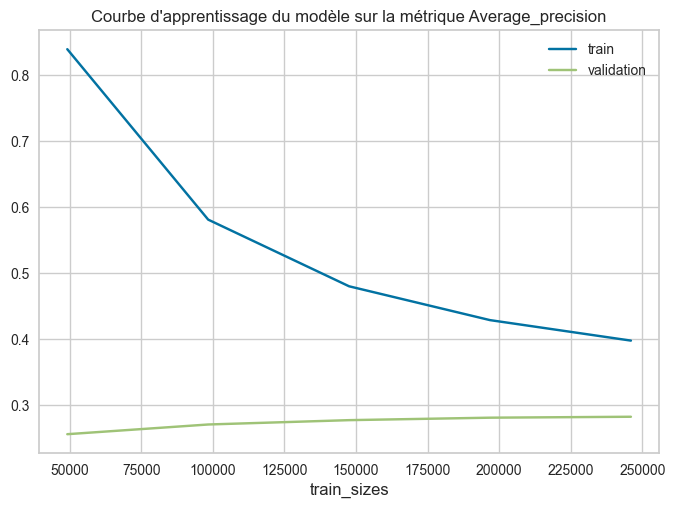

In [86]:
N, train_score, val_score= learning_curve(final_pipeline, X, y, train_sizes=np.linspace(0.2, 1.0, 5), scoring='average_precision')
print(N)
plt.plot(N, train_score.mean(axis = 1), label = 'train')
plt.plot(N, val_score.mean(axis= 1), label='validation')
plt.xlabel('train_sizes')
plt.title("Courbe d'apprentissage du modèle sur la métrique Average_precision")
plt.legend()

On remarque que la courbe de l'ensemble de validation s'approche de la courbe de l'ensemble d'apprentissage à mesure que la taille de l'ensemble d'apprentissage augmente.   
Cela est bon signe et indique que le modèle est en train de généraliser et n'est donc pas en suradaptation (courbe de l'ensemble d'apprentissage est en constante amélioration tandis que la courbe de l'ensemble de validation s'améliore initialement mais commence à stagner ou à décliner).

### Importance et Interpretation des features 

Text(0.5, 1.0, 'Importance des variables selon le modèle LGBM Classifier')

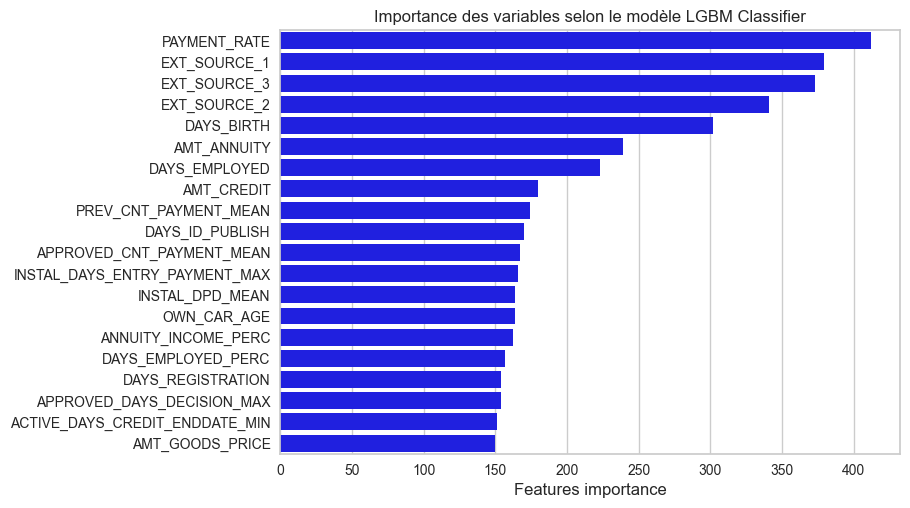

In [89]:
indices = np.argsort(final_pipeline.named_steps['lgbmclassifier'].feature_importances_)[::-1]
features = []
for i in range(20):
    features.append(X.columns[indices[i]]) 
sns.barplot(x=final_model.feature_importances_[indices[range(20)]], y=features, color=("blue"))
plt.xlabel('Features importance')
plt.title("Importance des variables selon le modèle LGBM Classifier")

**Remarque**: On remarque que les features donnant le plus d'importance à la prédiction du modèle sont :   

-PAYMENT RATE : Taux du crédit.  
-EXT_SOURCE 1, EXT_SOURCE 3 et EXT_SOURCE 2.     
-DAYS_BIRTH : L'age du client.  
-AMT_ANNUITY: Annuité de la demande de crédit.   
-AMT_CREDIT: Montant du crédit.

#### Importance locale des features

100%|===================| 92237/92253 [14:35<00:00]        

Graphique de l'explication de la première prédiction :


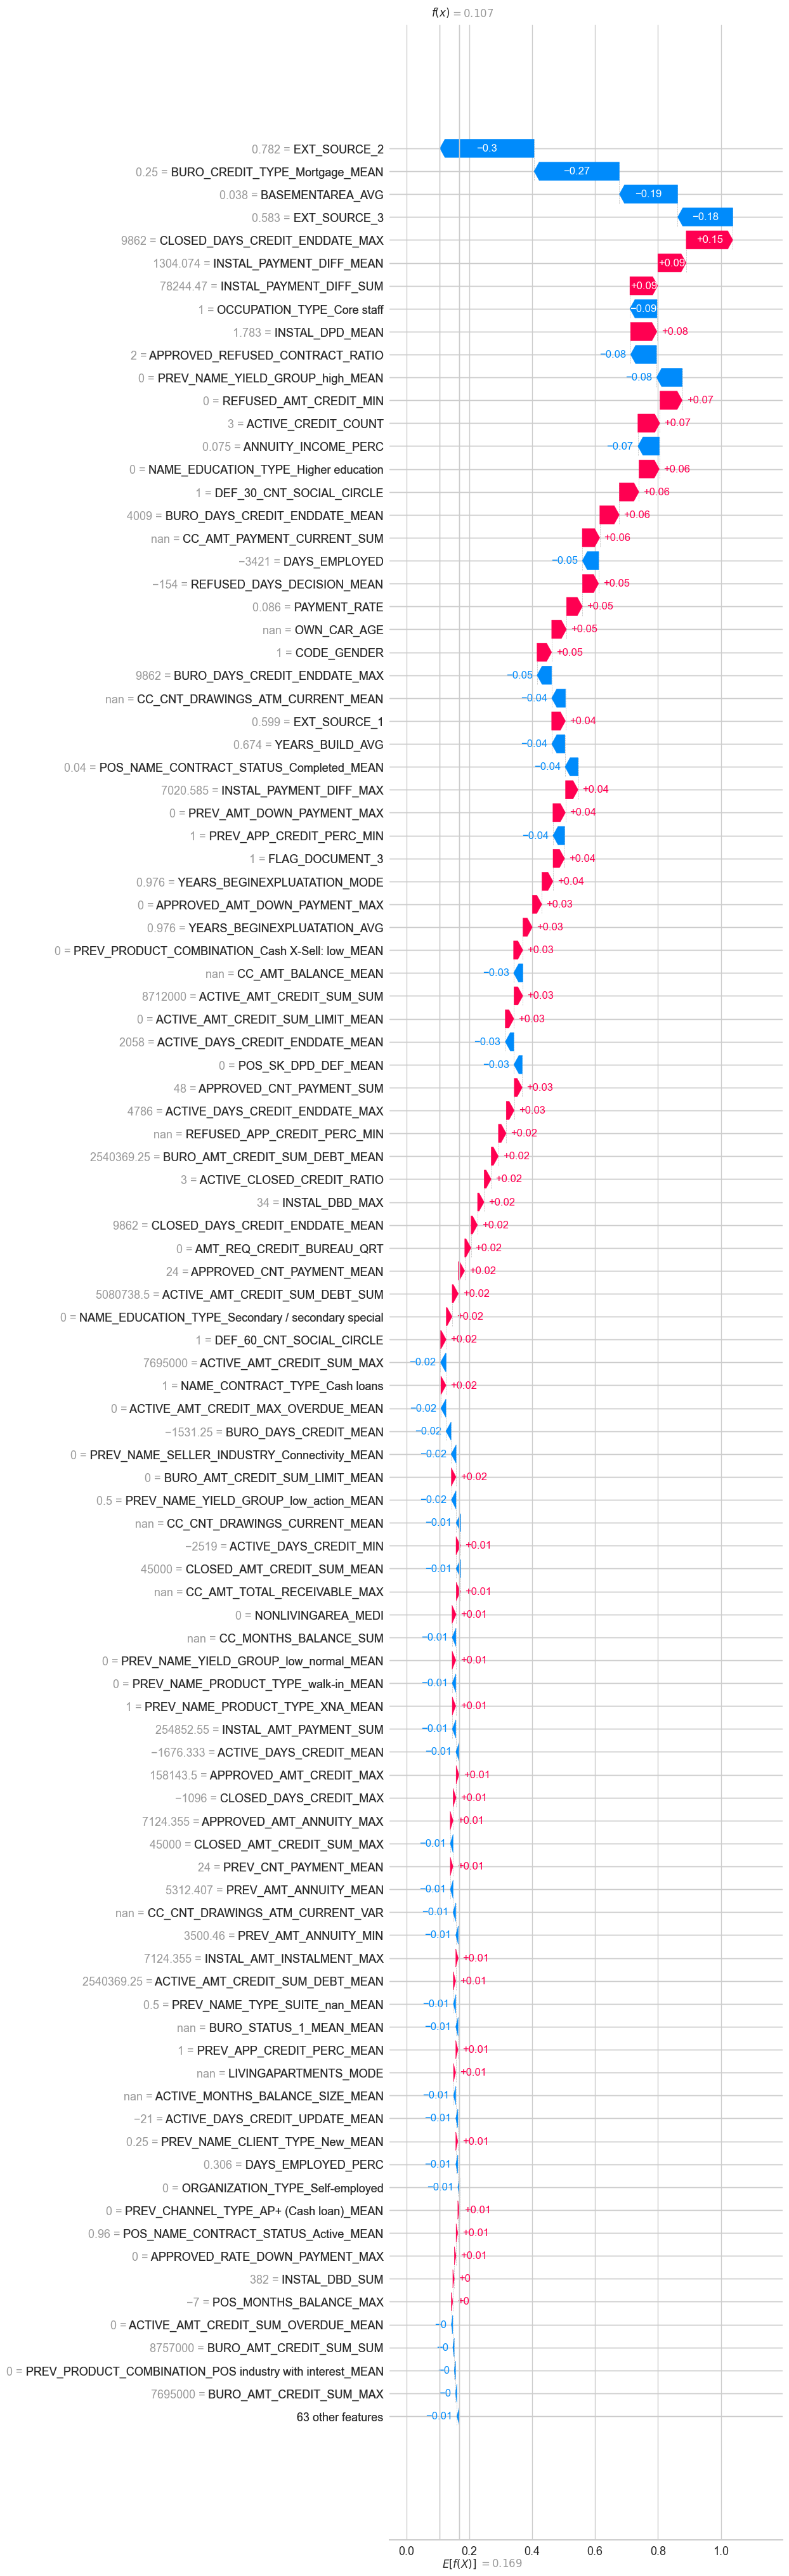

Graphique de tracé de décision : 


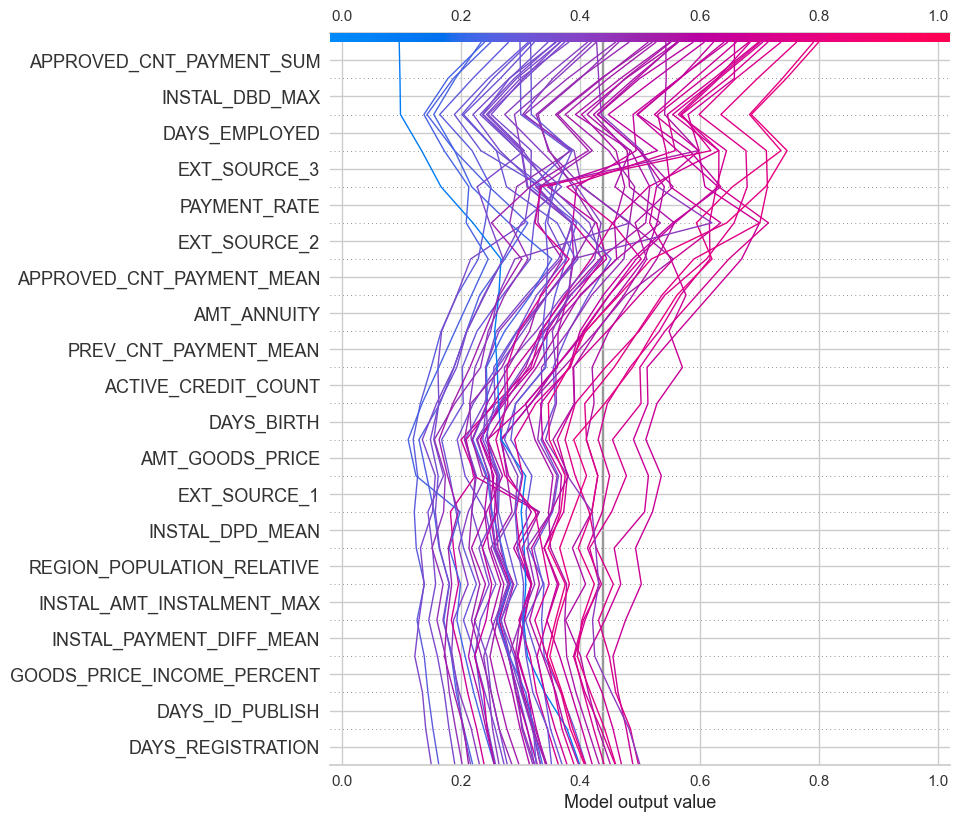

In [90]:
explainer = shap.Explainer(final_pipeline.named_steps['lgbmclassifier'], X_train)
shap_values = explainer(X_test, check_additivity=False)
print("Graphique de l'explication de la première prédiction :")
shap.plots.waterfall(shap_values[0], max_display= 100)

explainer = shap.TreeExplainer(final_pipeline.named_steps['lgbmclassifier'])
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]

select = range(50)
features = X_test.iloc[select]
features_display = X.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
        
print("Graphique de tracé de décision : ")
shap.decision_plot(expected_value, shap_values, features_display, link='logit')

#### Importance globale des features

100%|===================| 92211/92253 [14:35<00:00]        

Distribution des importances pour chaque caractéristique sur tous les échantillons :


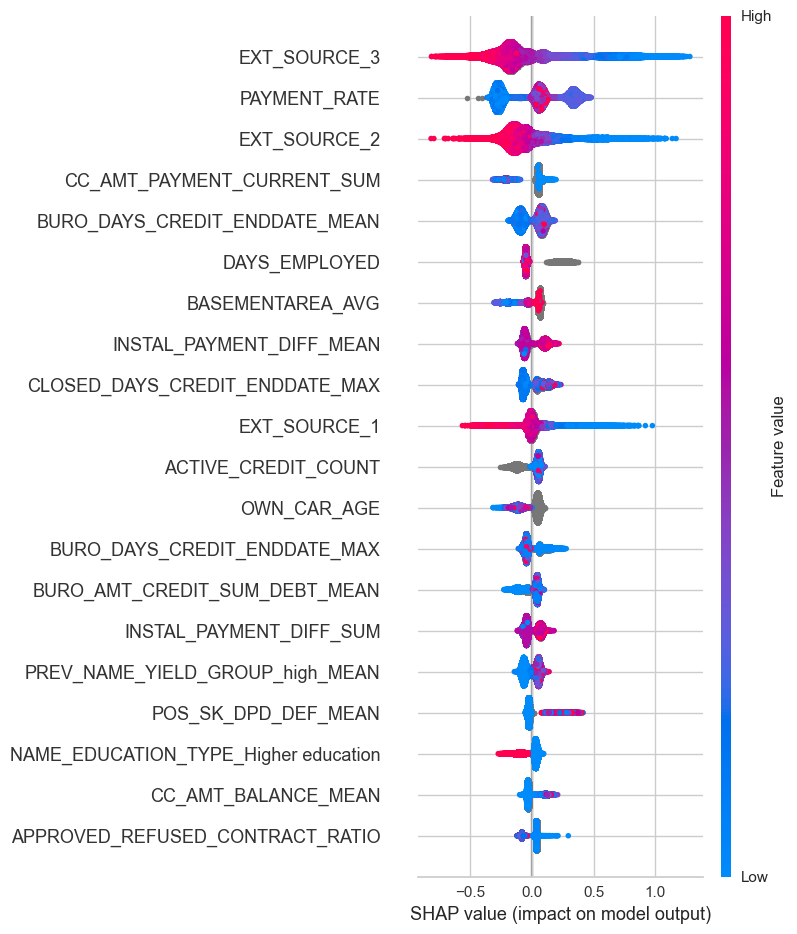

Importance globale de chaque caractéristique pour toutes les prédictions : 


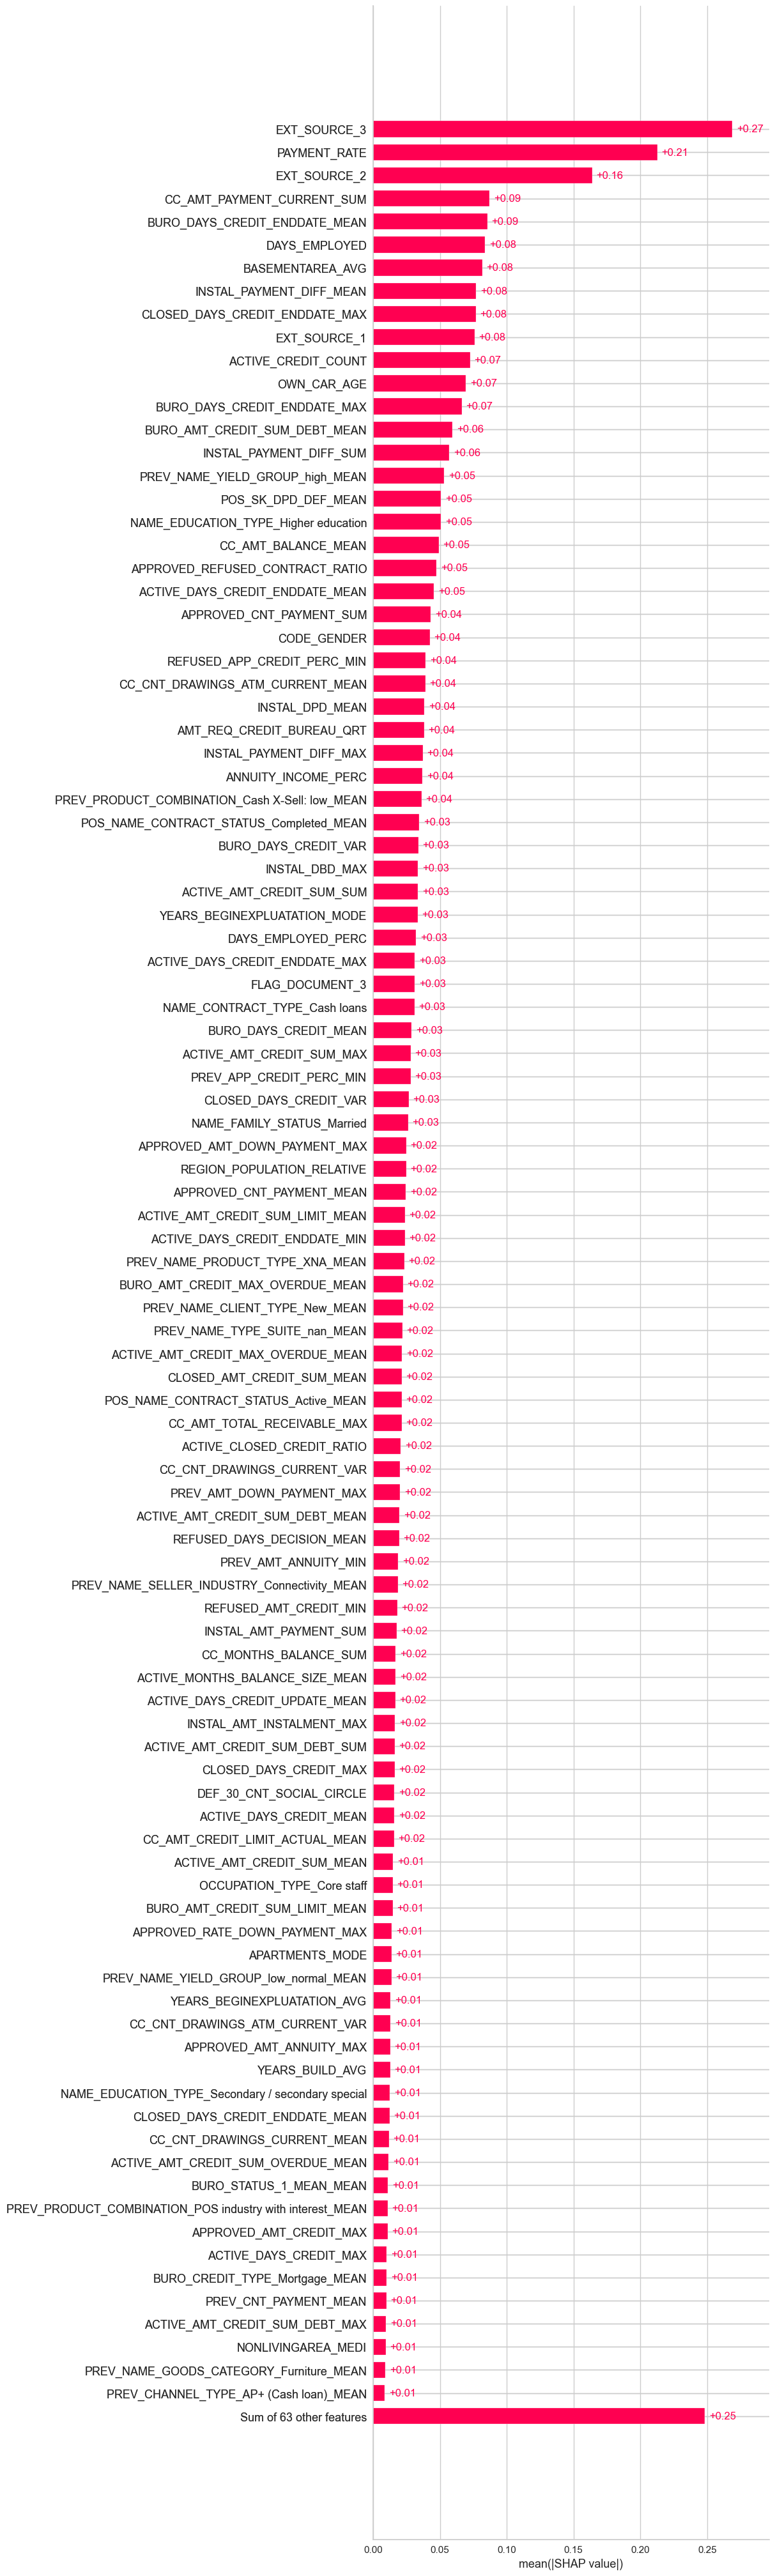

In [91]:
explainer = shap.Explainer(final_pipeline.named_steps['lgbmclassifier'], X_train)
shap_values = explainer(X_test, check_additivity=False)
print("Distribution des importances pour chaque caractéristique sur tous les échantillons :")
shap.summary_plot(shap_values)
print("Importance globale de chaque caractéristique pour toutes les prédictions : ")
shap.plots.bar(shap_values, max_display=100)

**Interprétation Shap**:  
Les sources exterieures 2 et 3 sont les features qui influencent le plus la prédiction du modèle avec le taux du crédit.
Plus les sources extérieures ont une valeur élevée, plus le client sera considéré comme fiable, au contraire si ses valeurs sont faibles, le client aura tendance à être prédit mauvais payeur.  
On retrouve notre variable ACTIVE_CREDIT_COUNT dans les 10 premières features explicative du modèle.